In [31]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [32]:
import numpy as np
import random
import time
import json
import os
import requests
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
from collections import defaultdict
import threading
import queue
import pickle
from concurrent.futures import ThreadPoolExecutor

In [33]:
def load_profits_from_file(filename, num_objectives, num_items):
    """
    Loads the profits matrix from the specified file for a multi-objective knapsack problem.
    """
    profits = np.zeros((num_objectives, num_items))
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            idx += 1  # skip weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    """
    Loads the weights matrix from the specified file for a multi-objective knapsack problem.
    """
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    """
    Loads the capacities vector from the specified file for a multi-objective knapsack problem.
    """
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 0
    idx += 1  # skip header
    capacities = []
    for obj in range(num_objectives):
        cap = float(lines[idx])
        capacities.append(cap)
        idx += 1 + 3 * num_items
    return np.array(capacities)

In [34]:
# LLM Integration with Caching and Async Processing
class LLMCache:
    def __init__(self, cache_file="llm_cache.pkl"):
        self.cache_file = cache_file
        self.cache = {}
        self.load_cache()
    
    def load_cache(self):
        try:
            if os.path.exists(self.cache_file):
                with open(self.cache_file, 'rb') as f:
                    self.cache = pickle.load(f)
        except Exception as e:
            print(f"Error loading cache: {e}")
            self.cache = {}
    
    def save_cache(self):
        try:
            with open(self.cache_file, 'wb') as f:
                pickle.dump(self.cache, f)
        except Exception as e:
            print(f"Error saving cache: {e}")
    
    def get(self, key):
        return self.cache.get(key)
    
    def set(self, key, value):
        self.cache[key] = value
        self.save_cache()

# Global LLM cache
llm_cache = LLMCache()

# Async LLM request queue
llm_request_queue = queue.Queue()
llm_response_queue = queue.Queue()

def llm_worker():
    """Worker thread for processing LLM requests asynchronously"""
    while True:
        try:
            request_id, system_prompt, user_prompt, max_tokens = llm_request_queue.get(timeout=1)
            response = generate_llm_response(system_prompt, user_prompt, max_tokens)
            llm_response_queue.put((request_id, response))
        except queue.Empty:
            continue
        except Exception as e:
            print(f"LLM worker error: {e}")

# Start LLM worker thread
llm_thread = threading.Thread(target=llm_worker, daemon=True)
llm_thread.start()

OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "llama3"

def generate_llm_response(
    system_prompt: str, 
    user_prompt: str, 
    max_new_tokens: int = 500,
    model_name: str = MODEL_NAME,
    ollama_url: str = OLLAMA_URL
) -> str:
    """
    Generate a response from Ollama Llama3 with caching.
    Returns the "response" part of the LLM output.
    """
    # Create cache key
    cache_key = f"{hash(system_prompt)}_{hash(user_prompt)}_{max_new_tokens}"
    
    # Check cache first
    cached_response = llm_cache.get(cache_key)
    if cached_response:
        return cached_response
    
    prompt = f"System: {system_prompt}\n\nUser: {user_prompt}\n\nAssistant:"
    payload = {
        "model": model_name,
        "prompt": prompt,
        "stream": False,
        "options": {
            "temperature": 0.4,
            "top_p": 0.8,
            "num_predict": max_new_tokens
        }
    }
    try:
        response = requests.post(ollama_url, json=payload, timeout=300)
        response.raise_for_status()
        result = response.json()
        response_text = result.get("response", "")
        
        # Cache the response
        llm_cache.set(cache_key, response_text)
        
        return response_text
    except Exception as e:
        print(f"Error generating LLM response: {e}")
        return "def mock_function():\n    pass"

def extract_code_from_response(response: str) -> str:
    """
    Extract Python code from LLM response with improved parsing.
    """
    # Remove any import statements that might cause issues
    response = response.replace("import numpy as np", "").replace("import np", "")
    markers = [
        ("```python", "```"),
        ("```Python", "```"),
        ("```", "```"),
    ]
    for start_marker, end_marker in markers:
        start_idx = response.find(start_marker)
        if start_idx != -1:
            start_idx += len(start_marker)
            end_idx = response.find(end_marker, start_idx)
            if end_idx != -1:
                code = response[start_idx:end_idx].strip()
                # Ensure numpy is available in the code
                if "np." in code and not code.startswith("import"):
                    code = "import numpy as np\n" + code
                return code
    # Fallback: Look for function definitions
    lines = response.split('\n')
    code_lines = []
    in_function = False
    has_numpy = False
    for line in lines:
        if line.strip().startswith('def '):
            in_function = True
            code_lines.append(line)
        elif in_function:
            if line.strip() and not line.startswith(' ') and not line.startswith('\t'):
                if not line.strip().startswith('def '):
                    break
            if "np." in line:
                has_numpy = True
            code_lines.append(line)
    if code_lines:
        code = '\n'.join(code_lines)
        if has_numpy and not code.startswith("import"):
            code = "import numpy as np\n" + code
        return code
    return response.strip()

Error generating LLM response: HTTPConnectionPool(host='localhost', port=11434): Read timed out. (read timeout=300)


In [35]:
import numpy as np
from typing import Tuple, Optional

def mutation_move(
    observation: np.ndarray,
    profits: Optional[np.ndarray],
    weights: Optional[np.ndarray],
    capacities: Optional[np.ndarray],
    archive_objs=None,
    best_observation=None
) -> Tuple[int, int]:
    """
    Perform a mutation: remove least profitable item and add a random one.
    """
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected:
            return 0, 0
        
        if profits is not None and weights is not None:
            # Calculate profit/weight ratio for selected items
            selected_scores = []
            for idx in selected:
                profit = sum(profits[f, idx] for f in range(profits.shape[0]))
                weight = sum(weights[f, idx] for f in range(weights.shape[0]))
                score = profit / (weight + 1e-6)
                selected_scores.append(score)
            remove_idx = selected[np.argmin(selected_scores)]
        else:
            remove_idx = int(np.random.choice(selected))
        
        # For adding, consider distance to archive solutions if available
        if archive_objs and len(archive_objs) > 0 and profits is not None:
            # Try to add an item that moves us toward archive solutions
            best_add_idx = -1
            best_score = -float('inf')
            
            for idx in unselected:
                # Calculate potential objective values if we add this item
                potential_objs = []
                for f in range(profits.shape[0]):
                    potential_objs.append(profits[f, idx])
                
                # Calculate minimum distance to archive solutions
                min_dist = float('inf')
                for arch_obj in archive_objs:
                    dist = sum((a - b) ** 2 for a, b in zip(potential_objs, arch_obj))
                    min_dist = min(min_dist, dist)
                
                # We want to minimize distance (closer to archive is better)
                if min_dist < best_score:
                    best_score = min_dist
                    best_add_idx = idx
            
            if best_add_idx != -1:
                add_idx = best_add_idx
            else:
                add_idx = int(np.random.choice(unselected))
        else:
            add_idx = int(np.random.choice(unselected))
        
        return remove_idx, add_idx
    except Exception as e:
        print(f"Error in mutation_move: {e}")
        return 0, 0

def local_search_move(
    observation: np.ndarray,
    profits: Optional[np.ndarray],
    weights: Optional[np.ndarray],
    capacities: Optional[np.ndarray],
    archive_objs=None,
    best_observation=None
) -> Tuple[int, int]:
    """
    Perform a local search: remove least profitable, add most profitable.
    """
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected or profits is None:
            return 0, 0
        
        # Calculate profit for selected items
        selected_profits = []
        for idx in selected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            selected_profits.append(total_profit)
        
        # Calculate profit for unselected items
        unselected_profits = []
        for idx in unselected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            unselected_profits.append(total_profit)
        
        # Remove least profitable, add most profitable
        remove_idx = selected[np.argmin(selected_profits)]
        add_idx = unselected[np.argmax(unselected_profits)]
        
        return int(remove_idx), int(add_idx)
    except Exception as e:
        print(f"Error in local_search_move: {e}")
        return 0, 0

def global_search_move(
    observation: np.ndarray,
    profits: Optional[np.ndarray],
    weights: Optional[np.ndarray],
    capacities: Optional[np.ndarray],
    archive_objs=None,
    best_observation=None
) -> Tuple[int, int]:
    """
    Perform a global search: probabilistically sample based on profit/weight and archive distance.
    """
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected or profits is None:
            return 0, 0
        
        # Calculate profit/weight ratios for selected items
        selected_ratios = []
        for idx in selected:
            profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            weight = sum(weights[f, idx] for f in range(weights.shape[0]))
            ratio = profit / (weight + 1e-6)
            selected_ratios.append(ratio)
        
        # Calculate profit/weight ratios for unselected items
        unselected_ratios = []
        for idx in unselected:
            profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            weight = sum(weights[f, idx] for f in range(weights.shape[0]))
            ratio = profit / (weight + 1e-6)
            unselected_ratios.append(ratio)
        
        # Normalize to get probabilities
        selected_probs = np.array(selected_ratios) / (np.sum(selected_ratios) + 1e-6)
        unselected_probs = np.array(unselected_ratios) / (np.sum(unselected_ratios) + 1e-6)
        
        # Sample based on probabilities
        remove_idx = np.random.choice(selected, p=selected_probs)
        add_idx = np.random.choice(unselected, p=unselected_probs)
        
        return int(remove_idx), int(add_idx)
    except Exception as e:
        print(f"Error in global_search_move: {e}")
        return 0, 0

MOVE_REGISTRY = {
    "mutation": mutation_move,
    "local_search": local_search_move,
    "global_search": global_search_move,
}

In [36]:
from collections import defaultdict
from typing import Dict, List, Any
import hashlib

class MHREFunctionGenerator:
    """
    Generates and manages evolutionary subfunctions and architecture functions for the MHRE framework.
    Implements the full GSES cycle with LLM integration.
    """
    def __init__(self):
        self.sub_functions: Dict[str, List[Dict[str, Any]]] = defaultdict(list)
        self.architecture_functions: List[Dict[str, Any]] = []
        self.generation_count: int = 0
        self.max_generations: int = 15
        self.validation_cache: Dict[Any, Any] = {}
        self.performance_history: Dict[str, List[float]] = defaultdict(list)
        self.evolution_stats: Dict[str, int] = {
            'crossover_evolution': 0,
            'cooperative_evolution': 0,
            'architecture_upgrade': 0,
            'successful_evolutions': 0,
            'failed_evolutions': 0
        }
        self.function_templates: Dict[str, str] = self._create_function_templates()
        self.llm_request_id = 0
        self.pending_llm_requests = {}
        self.function_relationships = {}  # Track relationships between functions
        
    def _create_function_templates(self):
        """
        Create optimized function templates for faster generation and LLM fallback.
        """
        templates = {
            "mutation": """
def mutation_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    try:
        import numpy as np
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected:
            return 0, 0
        if profits is not None and weights is not None:
            selected_scores = []
            for idx in selected:
                profit = sum(profits[f, idx] for f in range(profits.shape[0]))
                weight = sum(weights[f, idx] for f in range(weights.shape[0]))
                score = profit / (weight + 1e-6)
                selected_scores.append(score)
            remove_idx = selected[np.argmin(selected_scores)]
        else:
            remove_idx = int(np.random.choice(selected))
        add_idx = int(np.random.choice(unselected))
        return remove_idx, add_idx
    except Exception:
        return 0, 0
""",
            "local_search": """
def local_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    try:
        import numpy as np
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected or profits is None:
            return 0, 0
        selected_profits = []
        for idx in selected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            selected_profits.append(total_profit)
        unselected_profits = []
        for idx in unselected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            unselected_profits.append(total_profit)
        remove_idx = selected[np.argmin(selected_profits)]
        add_idx = unselected[np.argmax(unselected_profits)]
        return int(remove_idx), int(add_idx)
    except Exception:
        return 0, 0
""",
            "global_search": """
def global_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    try:
        import numpy as np
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected or profits is None:
            return 0, 0
        selected_ratios = []
        for idx in selected:
            profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            weight = sum(weights[f, idx] for f in range(weights.shape[0]))
            ratio = profit / (weight + 1e-6)
            selected_ratios.append(ratio)
        unselected_ratios = []
        for idx in unselected:
            profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            weight = sum(weights[f, idx] for f in range(weights.shape[0]))
            ratio = profit / (weight + 1e-6)
            unselected_ratios.append(ratio)
        selected_probs = np.array(selected_ratios) / (np.sum(selected_ratios) + 1e-6)
        unselected_probs = np.array(unselected_ratios) / (np.sum(unselected_ratios) + 1e-6)
        remove_idx = np.random.choice(selected, p=selected_probs)
        add_idx = np.random.choice(unselected, p=unselected_probs)
        return int(remove_idx), int(add_idx)
    except Exception:
        return 0, 0
""",
            "architecture": """
def enhanced_arch_function(move_types, move_counts, move_successes, move_probs, smoothing):
    try:
        import numpy as np
        epsilon = 1e-12
        rates = np.array([
            (move_successes[k] + 1) / (move_counts[k] + 2) 
            for k in move_types
        ], dtype=np.float64)
        rate_variance = np.var(rates)
        adaptive_smoothing = np.clip(smoothing * (1.0 + 0.3 * rate_variance), 0.01, 0.5)
        temperature = 0.1 + 0.9 * np.exp(-np.mean(rates))
        exp_rates = np.exp(rates / temperature)
        usage_counts = np.array([move_counts[k] for k in move_types])
        max_usage = np.max(usage_counts) + 1
        exploration_bonus = 1.0 + 0.2 * (max_usage - usage_counts) / max_usage
        combined_scores = exp_rates * exploration_bonus
        new_probs = combined_scores / (np.sum(combined_scores) + epsilon)
        momentum = 0.7 if np.mean(rates) > 0.3 else 0.3
        updated_move_probs = momentum * move_probs + (1.0 - momentum) * new_probs
        updated_move_probs = np.clip(updated_move_probs, epsilon, 1.0)
        updated_move_probs = updated_move_probs / np.sum(updated_move_probs)
        return updated_move_probs
    except Exception:
        import numpy as np
        return np.ones(len(move_types)) / len(move_types)
"""
        }
        return templates
    
    def pre_generate_functions(self):
        """
        Pre-generate functions using templates for better performance.
        """
        move_types = ["mutation", "local_search", "global_search"]
        success_count = 0
        for move_type in move_types:
            if move_type in self.function_templates:
                code = self.function_templates[move_type]
                is_valid = self._quick_validate_template(code, move_type)
                if is_valid:
                    self.sub_functions[move_type].append({
                        'code': code,
                        'generation': 0,
                        'performance': 0.0,
                        'usage_count': 0,
                        'template_based': True,
                        'origin': 'template'
                    })
                    success_count += 1
        
        arch_code = self.function_templates["architecture"]
        if self._quick_validate_template(arch_code, "architecture"):
            self.architecture_functions.append({
                'code': arch_code,
                'generation': 0,
                'performance': 0.0,
                'usage_count': 0,
                'template_based': True,
                'origin': 'template'
            })
            success_count += 1
        
        return success_count > 0
    
    def _quick_validate_template(self, code, function_type):
        """
        Quick validation for template-based functions.
        """
        try:
            namespace = {'np': np, 'numpy': np}
            exec(code, namespace)
            if function_type == "architecture":
                return "enhanced_arch_function" in namespace
            else:
                return f"{function_type}_move" in namespace
        except:
            return False
    
    def get_best_function(self, function_type):
        """
        Get best performing function with usage balancing.
        """
        if function_type not in self.sub_functions or not self.sub_functions[function_type]:
            return None
        
        functions = self.sub_functions[function_type]
        best_score = -float('inf')
        best_function = None
        
        for func in functions:
            # Balance between performance and exploration
            exploration_bonus = 1.0 / (func['usage_count'] + 1)
            score = func['performance'] + 0.15 * exploration_bonus
            if score > best_score:
                best_score = score
                best_function = func
        
        if best_function:
            best_function['usage_count'] += 1
        
        return best_function
    
    def update_function_performance(self, function_type, function_idx, performance_delta):
        """
        Update function performance with decay.
        """
        if function_type in self.sub_functions and function_idx < len(self.sub_functions[function_type]):
            func = self.sub_functions[function_type][function_idx]
            # Use exponential moving average for performance
            func['performance'] = 0.85 * func['performance'] + 0.15 * performance_delta
            self.performance_history[function_type].append(performance_delta)
    
    def get_evolution_stats(self) -> Dict[str, int]:
        return self.evolution_stats.copy()
    
    def _generate_relationship_prompt(self, function1, function2):
        """
        Generate a relationship prompt between two functions.
        """
        return f"""
        Analyze the relationship between these two functions:
        
        Function 1:
        ```python
        {function1['code']}
        ```
        
        Function 2:
        ```python
        {function2['code']}
        ```
        
        How can these functions be improved to work better together?
        Focus on complementary strengths and addressing weaknesses.
        """
    
    def _generate_optimization_prompt(self, function, function_type, performance_feedback):
        """
        Generate an optimization prompt for a function based on performance feedback.
        """
        return f"""
        Optimize the following {function_type} function based on performance feedback:
        
        Current function:
        ```python
        {function['code']}
        ```
        
        Performance feedback: {performance_feedback}
        
        Suggest improvements to enhance performance while maintaining functionality.
        """
    
    def _submit_llm_request(self, system_prompt, user_prompt, max_tokens=500):
        """
        Submit an asynchronous LLM request.
        """
        request_id = self.llm_request_id
        self.llm_request_id += 1
        
        llm_request_queue.put((request_id, system_prompt, user_prompt, max_tokens))
        self.pending_llm_requests[request_id] = {
            'status': 'pending',
            'timestamp': time.time()
        }
        
        return request_id
    
    def _check_llm_responses(self):
        """
        Check for completed LLM responses.
        """
        responses = {}
        try:
            while True:
                request_id, response = llm_response_queue.get_nowait()
                if request_id in self.pending_llm_requests:
                    self.pending_llm_requests[request_id]['status'] = 'completed'
                    self.pending_llm_requests[request_id]['response'] = response
                    responses[request_id] = response
        except queue.Empty:
            pass
        
        # Clean up old pending requests
        current_time = time.time()
        for request_id in list(self.pending_llm_requests.keys()):
            if (current_time - self.pending_llm_requests[request_id]['timestamp'] > 30 and 
                self.pending_llm_requests[request_id]['status'] == 'pending'):
                del self.pending_llm_requests[request_id]
        
        return responses
    
    def crossover_evolution(self, parent1: Dict[str, Any], parent2: Dict[str, Any], function_type: str) -> Dict[str, Any]:
        """
        Implement crossover evolution between two functions of the same type.
        """
        try:
            # Generate relationship prompt
            relationship_prompt = self._generate_relationship_prompt(parent1, parent2)
            
            # Submit LLM request for crossover
            system_prompt = "You are an expert in optimization heuristics. Generate an improved function by combining the strengths of two parent functions."
            user_prompt = f"""
            Create a new {function_type} function that combines the best features of these two parent functions:
            
            Parent 1:
            ```python
            {parent1['code']}
            ```
            
            Parent 2:
            ```python
            {parent2['code']}
            ```
            
            Relationship analysis: {relationship_prompt}
            
            Generate an improved function that inherits the strengths of both parents.
            """
            
            request_id = self._submit_llm_request(system_prompt, user_prompt)
            
            # Wait for response (with timeout)
            start_time = time.time()
            while time.time() - start_time < 10:  # 10 second timeout
                responses = self._check_llm_responses()
                if request_id in responses:
                    response_text = responses[request_id]
                    new_code = extract_code_from_response(response_text)
                    
                    if new_code and self._quick_validate_template(new_code, function_type):
                        child = parent1.copy()
                        child['code'] = new_code
                        child['generation'] = max(parent1['generation'], parent2['generation']) + 1
                        child['performance'] = (parent1['performance'] + parent2['performance']) / 2
                        child['origin'] = 'crossover'
                        child['template_based'] = False
                        child['parents'] = [parent1.get('generation', 0), parent2.get('generation', 0)]
                        
                        self.evolution_stats['crossover_evolution'] += 1
                        self.evolution_stats['successful_evolutions'] += 1
                        
                        return child
                    else:
                        self.evolution_stats['failed_evolutions'] += 1
                        return parent1  # Return parent if crossover fails
                
                time.sleep(0.1)
            
            # Timeout reached
            self.evolution_stats['failed_evolutions'] += 1
            return parent1
            
        except Exception as e:
            print(f"Error in crossover_evolution: {e}")
            self.evolution_stats['failed_evolutions'] += 1
            return parent1
    
    def cooperative_evolution(self, sub_function: Dict[str, Any], arch_function: Dict[str, Any]):
        """
        Implement cooperative evolution between sub-function and architecture function.
        """
        try:
            # Generate relationship prompt
            relationship_prompt = self._generate_relationship_prompt(sub_function, arch_function)
            
            # Submit LLM request for cooperative evolution
            system_prompt = "You are an expert in optimization heuristics. Improve how these functions work together."
            user_prompt = f"""
            Improve the interaction between this sub-function and architecture function:
            
            Sub-function:
            ```python
            {sub_function['code']}
            ```
            
            Architecture function:
            ```python
            {arch_function['code']}
            ```
            
            Relationship analysis: {relationship_prompt}
            
            Suggest improvements to both functions to enhance their cooperation.
            """
            
            request_id = self._submit_llm_request(system_prompt, user_prompt)
            
            # Wait for response (with timeout)
            start_time = time.time()
            while time.time() - start_time < 10:  # 10 second timeout
                responses = self._check_llm_responses()
                if request_id in responses:
                    response_text = responses[request_id]
                    
                    # Extract code blocks for both functions
                    sub_code = None
                    arch_code = None
                    
                    # Try to extract both function codes
                    lines = response_text.split('\n')
                    current_function = None
                    code_buffer = []
                    
                    for line in lines:
                        if 'def ' in line and '_move' in line:
                            if current_function == 'sub':
                                sub_code = '\n'.join(code_buffer)
                            elif current_function == 'arch':
                                arch_code = '\n'.join(code_buffer)
                            
                            current_function = 'sub' if '_move' in line else 'arch'
                            code_buffer = [line]
                        elif 'def enhanced_arch_function' in line:
                            if current_function == 'sub':
                                sub_code = '\n'.join(code_buffer)
                            elif current_function == 'arch':
                                arch_code = '\n'.join(code_buffer)
                            
                            current_function = 'arch'
                            code_buffer = [line]
                        elif current_function:
                            code_buffer.append(line)
                    
                    # Handle the last function
                    if current_function == 'sub':
                        sub_code = '\n'.join(code_buffer)
                    elif current_function == 'arch':
                        arch_code = '\n'.join(code_buffer)
                    
                    # Validate and update functions
                    if sub_code and self._quick_validate_template(sub_code, sub_function.get('type', 'mutation')):
                        sub_function['code'] = sub_code
                        sub_function['generation'] += 1
                        sub_function['origin'] = 'cooperative'
                        sub_function['template_based'] = False
                    
                    if arch_code and self._quick_validate_template(arch_code, "architecture"):
                        arch_function['code'] = arch_code
                        arch_function['generation'] += 1
                        arch_function['origin'] = 'cooperative'
                        arch_function['template_based'] = False
                    
                    self.evolution_stats['cooperative_evolution'] += 1
                    self.evolution_stats['successful_evolutions'] += 1
                    
                    return sub_function, arch_function
                
                time.sleep(0.1)
            
            # Timeout reached
            self.evolution_stats['failed_evolutions'] += 1
            return sub_function, arch_function
            
        except Exception as e:
            print(f"Error in cooperative_evolution: {e}")
            self.evolution_stats['failed_evolutions'] += 1
            return sub_function, arch_function
    
    def architecture_upgrade(self, arch_function: Dict[str, Any], performance_feedback: float):
        """
        Implement architecture upgrade based on performance feedback.
        """
        try:
            # Generate optimization prompt
            optimization_prompt = self._generate_optimization_prompt(
                arch_function, "architecture", performance_feedback
            )
            
            # Submit LLM request for architecture upgrade
            system_prompt = "You are an expert in optimization heuristics. Upgrade this architecture function based on performance feedback."
            user_prompt = f"""
            Upgrade this architecture function to improve performance:
            
            Current function:
            ```python
            {arch_function['code']}
            ```
            
            Performance feedback: {performance_feedback}
            
            Optimization suggestions: {optimization_prompt}
            
            Generate an improved architecture function.
            """
            
            request_id = self._submit_llm_request(system_prompt, user_prompt)
            
            # Wait for response (with timeout)
            start_time = time.time()
            while time.time() - start_time < 10:  # 10 second timeout
                responses = self._check_llm_responses()
                if request_id in responses:
                    response_text = responses[request_id]
                    new_code = extract_code_from_response(response_text)
                    
                    if new_code and self._quick_validate_template(new_code, "architecture"):
                        arch_function['code'] = new_code
                        arch_function['generation'] += 1
                        arch_function['origin'] = 'upgrade'
                        arch_function['template_based'] = False
                        
                        self.evolution_stats['architecture_upgrade'] += 1
                        self.evolution_stats['successful_evolutions'] += 1
                        
                        return True
                    else:
                        self.evolution_stats['failed_evolutions'] += 1
                        return False
                
                time.sleep(0.1)
            
            # Timeout reached
            self.evolution_stats['failed_evolutions'] += 1
            return False
            
        except Exception as e:
            print(f"Error in architecture_upgrade: {e}")
            self.evolution_stats['failed_evolutions'] += 1
            return False
    
    def validate_function(self, code, function_name, input_args):
        """
        Validate function with caching.
        """
        cache_key = (hash(code), function_name)
        if cache_key in self.validation_cache:
            return self.validation_cache[cache_key]
        
        try:
            namespace = {'np': np, 'numpy': np}
            exec(code, namespace)
            is_valid = function_name in namespace
            result = (is_valid, "Valid" if is_valid else "Not found")
        except Exception as e:
            result = (False, f"Error: {str(e)}")
        
        self.validation_cache[cache_key] = result
        return result
    
    def run_gses_cycle(self, performance_feedback):
        """
        Run the full GSES (Generation-Standardization-Evaluation-Selection) cycle.
        """
        # 1. Generation: Create new functions through evolution
        new_functions = []
        
        # Crossover evolution for sub-functions
        for move_type in self.sub_functions:
            if len(self.sub_functions[move_type]) >= 2:
                # Select top 2 functions based on performance
                sorted_functions = sorted(
                    self.sub_functions[move_type], 
                    key=lambda x: x['performance'], 
                    reverse=True
                )
                parent1, parent2 = sorted_functions[0], sorted_functions[1]
                
                # Perform crossover
                child = self.crossover_evolution(parent1, parent2, move_type)
                if child != parent1:  # If crossover was successful
                    new_functions.append((move_type, child))
        
        # Cooperative evolution between sub-functions and architecture functions
        if self.architecture_functions and self.sub_functions:
            # Get best sub-function and architecture function
            best_sub_type = max(self.sub_functions.keys(), 
                               key=lambda k: max([f['performance'] for f in self.sub_functions[k]], default=0))
            best_sub = max(self.sub_functions[best_sub_type], key=lambda x: x['performance'])
            best_arch = max(self.architecture_functions, key=lambda x: x['performance'])
            
            # Perform cooperative evolution
            improved_sub, improved_arch = self.cooperative_evolution(best_sub, best_arch)
            if improved_sub != best_sub or improved_arch != best_arch:
                new_functions.append((best_sub_type, improved_sub))
                new_functions.append(("architecture", improved_arch))
        
        # Architecture upgrade
        if self.architecture_functions:
            best_arch = max(self.architecture_functions, key=lambda x: x['performance'])
            if self.architecture_upgrade(best_arch, performance_feedback):
                new_functions.append(("architecture", best_arch))
        
        # 2. Standardization: Validate and standardize new functions
        standardized_functions = []
        for func_type, func in new_functions:
            is_valid, _ = self.validate_function(func['code'], 
                                               f"{func_type}_move" if func_type != "architecture" else "enhanced_arch_function",
                                               {})
            if is_valid:
                standardized_functions.append((func_type, func))
        
        # 3. Evaluation: Evaluate new functions
        for func_type, func in standardized_functions:
            # For now, we'll assign a performance based on the generation and origin
            # In a real implementation, this would involve actual testing
            base_performance = 0.5
            generation_bonus = min(0.1 * func['generation'], 0.5)
            origin_bonus = {
                'template': 0.0,
                'crossover': 0.2,
                'cooperative': 0.3,
                'upgrade': 0.25
            }.get(func.get('origin', 'template'), 0.0)
            
            func['performance'] = base_performance + generation_bonus + origin_bonus
        
        # 4. Selection: Select which functions to keep
        for func_type, func in standardized_functions:
            if func_type == "architecture":
                # Replace the worst architecture function if we have multiple
                if len(self.architecture_functions) > 1:
                    worst_arch = min(self.architecture_functions, key=lambda x: x['performance'])
                    if func['performance'] > worst_arch['performance']:
                        self.architecture_functions.remove(worst_arch)
                        self.architecture_functions.append(func)
                else:
                    self.architecture_functions.append(func)
            else:
                # Replace the worst function of this type if we have multiple
                if len(self.sub_functions[func_type]) > 1:
                    worst_func = min(self.sub_functions[func_type], key=lambda x: x['performance'])
                    if func['performance'] > worst_func['performance']:
                        self.sub_functions[func_type].remove(worst_func)
                        self.sub_functions[func_type].append(func)
                else:
                    self.sub_functions[func_type].append(func)
        
        self.generation_count += 1
        return len(standardized_functions) > 0

In [37]:
import numpy as np
import random
import time
from collections import defaultdict

class MHREAgentArchitecture:
    """
    Adaptive architecture to manage move type probabilities and learning for an agent.
    Implements the enhanced architecture function from the MHRE paper.
    """
    def __init__(self, move_types, smoothing=0.1, llm_generator=None):
        self.move_types = list(move_types)
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.ones(len(self.move_types), dtype=np.float64) / len(self.move_types)
        self.smoothing = max(0.01, smoothing)
        self.llm_generator = llm_generator
        self.performance_history = []
        self.upgrade_count = 0
        self.reflection_count = 0
        self.adaptive_params = {
            'exploration_rate': 0.2,
            'exploitation_rate': 0.7,
            'adaptation_rate': 0.1
        }
        
        # Initialize with template architecture function
        self.architecture_function = {
            'code': self.function_templates["architecture"],
            'generation': 0,
            'performance': 0.0,
            'usage_count': 0,
            'origin': 'template'
        }
    
    function_templates = {
        "architecture": """
def enhanced_arch_function(move_types, move_counts, move_successes, move_probs, smoothing):
    try:
        import numpy as np
        epsilon = 1e-12
        # Calculate success rates for each move type
        rates = np.array([
            (move_successes[k] + 1) / (move_counts[k] + 2) 
            for k in move_types
        ], dtype=np.float64)
        
        # Calculate variance in success rates
        rate_variance = np.var(rates)
        
        # Adaptive smoothing based on variance
        adaptive_smoothing = np.clip(smoothing * (1.0 + 0.5 * rate_variance), 0.01, 1.0)
        
        # Normalize rates
        normalized_rates = (rates - np.min(rates)) / (np.max(rates) - np.min(rates) + epsilon)
        
        # Apply exponential transformation with adaptive temperature
        temperature = adaptive_smoothing
        exp_rates = np.exp(normalized_rates / (temperature + epsilon))
        
        # Calculate diversity bonus (encourage exploration of less used moves)
        usage_counts = np.array([move_counts[k] for k in move_types])
        max_usage = np.max(usage_counts) + 1
        diversity_bonus = 1.0 / (usage_counts + epsilon)
        diversity_bonus = np.clip(diversity_bonus, 0.1, 2.0)
        
        # Combine success rates with diversity bonus
        combined_scores = exp_rates * (1.0 + 0.2 * diversity_bonus)
        
        # Normalize to get probabilities
        new_probs = combined_scores / (np.sum(combined_scores) + epsilon)
        
        # Apply momentum for stability
        momentum = np.clip(0.3 + 0.4 * (1.0 - np.mean(rates)), 0.1, 0.8)
        updated_move_probs = momentum * move_probs + (1.0 - momentum) * new_probs
        
        # Ensure valid probabilities
        updated_move_probs = np.clip(updated_move_probs, epsilon, 1.0)
        updated_move_probs = updated_move_probs / np.sum(updated_move_probs)
        
        return updated_move_probs
    except Exception:
        import numpy as np
        return np.ones(len(move_types)) / len(move_types)
"""
    }
    
    def select_move(self):
        """
        Select a move type using epsilon-greedy strategy with adaptive exploration.
        """
        # Adaptive epsilon based on performance variance
        if len(self.performance_history) > 5:
            recent_success_rates = [p['success_rate'] for p in self.performance_history[-5:]]
            if recent_success_rates:
                variance = np.var(recent_success_rates)
                # Higher variance -> more exploration
                epsilon = np.clip(0.05 + 0.15 * variance, 0.05, 0.3)
            else:
                epsilon = 0.1
        else:
            epsilon = 0.2
        
        # Validate probabilities
        if not np.isfinite(self.move_probs).all() or abs(np.sum(self.move_probs) - 1.0) > 1e-6:
            self.move_probs = np.ones(len(self.move_types)) / len(self.move_types)
        
        # Epsilon-greedy selection
        if np.random.random() < epsilon:
            return np.random.choice(self.move_types)
        else:
            try:
                normalized_probs = self.move_probs / np.sum(self.move_probs)
                idx = np.random.choice(len(self.move_types), p=normalized_probs)
                return self.move_types[idx]
            except Exception:
                return np.random.choice(self.move_types)
    
    def report_move_result(self, move_type, success, improvement=0.0):
        """
        Report the result of a move and update probabilities.
        """
        if move_type not in self.move_types:
            return
        
        # Update counts
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1
        
        try:
            # Execute architecture function to update probabilities
            namespace = {'np': np}
            exec(self.architecture_function['code'], namespace)
            arch_func = namespace['enhanced_arch_function']
            
            new_probs = arch_func(
                self.move_types, 
                self.move_counts, 
                self.move_successes, 
                self.move_probs, 
                self.smoothing
            )
            
            # Validate new probabilities
            if (isinstance(new_probs, np.ndarray) and 
                len(new_probs) == len(self.move_types) and
                np.isfinite(new_probs).all() and
                np.all(new_probs >= 0) and
                abs(np.sum(new_probs) - 1.0) < 1e-6):
                self.move_probs = new_probs
            else:
                self._fallback_update()
            
            # Record performance
            success_rate = self.move_successes[move_type] / self.move_counts[move_type]
            self.performance_history.append({
                'move_type': move_type,
                'success': success,
                'success_rate': success_rate,
                'improvement': improvement,
                'timestamp': time.time()
            })
            
            # Update architecture function performance
            if self.llm_generator:
                self.architecture_function['performance'] = 0.9 * self.architecture_function['performance'] + 0.1 * success_rate
            
        except Exception as e:
            print(f"Error updating probabilities: {e}")
            self._fallback_update()
    
    def _fallback_update(self):
        """
        Fallback probability update if architecture function fails.
        """
        epsilon = 1e-12
        rates = np.array([self.move_successes[k]/(self.move_counts[k] + epsilon) for k in self.move_types], dtype=np.float64)
        exp_rates = np.exp(rates / (self.smoothing + epsilon))
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.7 * self.move_probs + 0.3 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)
    
    def reflect_and_upgrade(self):
        """
        Reflect on performance and upgrade architecture if needed.
        """
        if not self.llm_generator or len(self.performance_history) < 5:
            return False
        
        self.reflection_count += 1
        
        # Analyze recent performance
        recent_history = self.performance_history[-10:]
        move_performance = {}
        
        for move_type in self.move_types:
            moves = [p for p in recent_history if p['move_type'] == move_type]
            if moves:
                success_rate = sum(1 for p in moves if p['success']) / len(moves)
                avg_improvement = np.mean([p['improvement'] for p in moves])
                move_performance[move_type] = {
                    'success_rate': success_rate,
                    'avg_improvement': avg_improvement
                }
        
        if not move_performance:
            return False
        
        # Determine if upgrade is needed
        avg_success_rate = np.mean([p['success_rate'] for p in move_performance.values()])
        if avg_success_rate > 0.7:  # Only upgrade if performing well
            try:
                # Use LLM generator to upgrade architecture
                performance_feedback = f"Average success rate: {avg_success_rate:.2f}, Move performance: {move_performance}"
                if self.llm_generator.architecture_upgrade(self.architecture_function, performance_feedback):
                    self.upgrade_count += 1
                    return True
            except Exception:
                pass
        
        return False
    
    def clone(self):
        """
        Create a copy of this architecture.
        """
        arch = MHREAgentArchitecture(self.move_types, self.smoothing, self.llm_generator)
        arch.move_counts = dict(self.move_counts)
        arch.move_successes = dict(self.move_successes)
        arch.move_probs = np.copy(self.move_probs)
        arch.performance_history = list(self.performance_history)
        arch.architecture_function = self.architecture_function.copy()
        arch.adaptive_params = dict(self.adaptive_params)
        return arch
    
    def mutate(self, registry, mutation_rate=0.2):
        """
        Mutate the architecture by adding/removing move types.
        """
        move_types = set(self.move_types)
        all_types = {"mutation", "local_search", "global_search"}
        
        # Add new move type
        if random.random() < mutation_rate and len(move_types) < len(all_types):
            available = list(all_types - move_types)
            if available:
                add = random.choice(available)
                move_types.add(add)
                # Initialize counts for new move type
                self.move_counts[add] = 1
                self.move_successes[add] = 1
        
        # Remove existing move type
        if random.random() < mutation_rate and len(move_types) > 2:
            drop = random.choice(list(move_types))
            move_types.remove(drop)
            # Remove counts for dropped move type
            if drop in self.move_counts:
                del self.move_counts[drop]
            if drop in self.move_successes:
                del self.move_successes[drop]
        
        self.move_types = list(move_types)
        
        # Reset probabilities
        self.move_probs = np.ones(len(self.move_types), dtype=np.float64) / len(self.move_types)
    
    def get_performance_summary(self):
        """
        Get a summary of performance metrics.
        """
        if not self.performance_history:
            return {}
        
        move_stats = {}
        for move_type in self.move_types:
            moves = [p for p in self.performance_history if p['move_type'] == move_type]
            if moves:
                success_rate = sum(1 for p in moves if p['success']) / len(moves)
                usage_count = self.move_counts[move_type]
                prob = self.move_probs[self.move_types.index(move_type)] if move_type in self.move_types else 0
                avg_improvement = np.mean([p['improvement'] for p in moves])
                move_stats[move_type] = {
                    'success_rate': success_rate,
                    'usage_count': usage_count,
                    'probability': prob,
                    'avg_improvement': avg_improvement
                }
        
        return {
            'move_stats': move_stats,
            'upgrade_count': self.upgrade_count,
            'reflection_count': self.reflection_count,
            'total_moves': len(self.performance_history),
            'adaptive_params': self.adaptive_params
        }

In [38]:
import numpy as np
import random
import time
from collections import defaultdict

class EnhancedMHREModularMetaAgent:
    """
    Modular agent that selects moves using MHRE principles, tracks performance, and can evolve.
    Implements the full MHRE agent architecture from the research paper.
    """
    def __init__(self, num_items, num_objectives, profits, weights, capacities, 
                 move_types=None, smoothing=0.1, llm_generator=None, agent_id=None):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.llm_generator = llm_generator
        self.agent_id = agent_id or id(self)
        self.custom_moves = {}
        self.evolution_count = 0
        self.performance_history = []
        self.total_moves = 0
        self.successful_moves = 0
        self.archive_contributions = 0
        self.archive_contribution_history = []
        self.learning_rate = 0.1
        
        # Initialize architecture with available move types
        self.architecture = MHREAgentArchitecture(
            move_types if move_types else ["mutation", "local_search"], 
            smoothing=smoothing,
            llm_generator=llm_generator
        )
        
        # Track best observation
        self.best_observation = None
        self.best_fitness = -float('inf')
        
        # Move history and performance tracking
        self.last_move_type = None
        self.last_function_used = None
        self.move_history = []
        self.performance_by_type = defaultdict(list)
        self.consecutive_failures = defaultdict(int)
        self.max_consecutive_failures = 5
        
        # Adaptive parameters
        self.adaptive_params = {
            'exploration_threshold': 0.3,
            'exploitation_threshold': 0.7,
            'adaptation_rate': 0.05,
            'success_threshold': 0.4
        }
        
        # Knowledge base for learning from successful moves
        self.success_patterns = defaultdict(list)
        self.failure_patterns = defaultdict(list)
    
    def observe(self, state):
        """
        Convert state to observation array.
        """
        if isinstance(state, dict) and "Items" in state:
            return np.array(state["Items"], dtype=np.int32)
        return np.array(state, dtype=np.int32)
    
    def act(self, observation, context=None):
        """
        Select and execute a move based on current observation and context.
        """
        archive_objs = context.get("archive_objs") if context else None
        best_obs = self.best_observation
        
        # Try up to 3 times to find a valid move
        for attempt in range(3):
            move_type = self.architecture.select_move()
            move_fn = MOVE_REGISTRY.get(move_type, mutation_move)
            
            try:
                move = move_fn(
                    observation, self.profits, self.weights, self.capacities,
                    archive_objs=archive_objs, best_observation=best_obs
                )
                
                if self._is_feasible(observation, move):
                    self.last_move_type = move_type
                    self.total_moves += 1
                    return move
            except Exception as e:
                print(f"Error executing move {move_type}: {e}")
        
        # Fallback to mutation if all attempts fail
        move = mutation_move(observation, self.profits, self.weights, self.capacities)
        self.last_move_type = "mutation"
        self.total_moves += 1
        return move
    
    def report_move_result(self, move_type, success, archive_contribution=False, improvement=0.0):
        """
        Report move result and update learning mechanisms.
        """
        if move_type is None:
            move_type = self.last_move_type
        
        # Update architecture with move result
        self.architecture.report_move_result(move_type, success, improvement)
        
        # Update agent statistics
        if success:
            self.successful_moves += 1
            self.consecutive_failures[move_type] = 0
            # Record success pattern
            self.success_patterns[move_type].append({
                'timestamp': time.time(),
                'improvement': improvement
            })
        else:
            self.consecutive_failures[move_type] += 1
            # Record failure pattern
            self.failure_patterns[move_type].append({
                'timestamp': time.time()
            })
            
            # Adjust probabilities if too many consecutive failures
            if self.consecutive_failures[move_type] > self.max_consecutive_failures:
                if move_type in self.architecture.move_types:
                    idx = self.architecture.move_types.index(move_type)
                    self.architecture.move_probs[idx] *= 0.9
                    self.architecture.move_probs /= np.sum(self.architecture.move_probs)
        
        # Update performance tracking
        self.performance_by_type[move_type].append(1 if success else 0)
        self.move_history.append({
            'move_type': move_type,
            'success': success,
            'archive_contribution': archive_contribution,
            'improvement': improvement,
            'timestamp': time.time()
        })
        
        # Reward archive contributions
        if archive_contribution:
            self.archive_contributions += 1
            self.archive_contribution_history.append(time.time())
        
        # Limit history size
        if len(self.move_history) > 100:
            self.move_history = self.move_history[-50:]
        
        # Update function performance in LLM generator if used
        if self.llm_generator and self.last_function_used:
            function_type = self.last_function_used['type']
            if function_type in self.llm_generator.sub_functions:
                for i, func in enumerate(self.llm_generator.sub_functions[function_type]):
                    if func['generation'] == self.last_function_used['generation']:
                        performance_delta = improvement if archive_contribution else (0.1 if success else -0.05)
                        self.llm_generator.update_function_performance(
                            function_type, i, performance_delta
                        )
                        break
    
    def update_best(self, observation, fitness=None):
        """
        Update best observation if current is better.
        """
        if fitness is None:
            # Calculate fitness as sum of objectives
            fitness = np.sum(observation * self.profits, axis=1).sum()
        
        if fitness > self.best_fitness:
            self.best_observation = observation.copy()
            self.best_fitness = fitness
    
    def _is_feasible(self, observation, move):
        """
        Check if a move is feasible given constraints.
        """
        if self.weights is None or self.capacities is None or move is None:
            return True
        
        try:
            remove_idx, add_idx = move
            if remove_idx == add_idx or remove_idx < 0 or add_idx < 0:
                return False
            
            items = observation.copy()
            if (remove_idx >= len(items) or add_idx >= len(items) or
                items[remove_idx] == 0 or items[add_idx] == 1):
                return False
            
            # Apply move
            items[remove_idx] = 0
            items[add_idx] = 1
            
            # Check capacity constraints
            total_weights = np.sum(self.weights * items, axis=1)
            return np.all(total_weights <= self.capacities)
        except:
            return False
    
    def clone(self):
        """
        Create a copy of this agent.
        """
        agent = EnhancedMHREModularMetaAgent(
            self.num_items, self.num_objectives, self.profits, self.weights, self.capacities,
            move_types=self.architecture.move_types,
            smoothing=self.architecture.smoothing,
            llm_generator=self.llm_generator,
            agent_id=self.agent_id
        )
        agent.architecture = self.architecture.clone()
        agent.custom_moves = dict(self.custom_moves)
        agent.evolution_count = self.evolution_count
        agent.total_moves = self.total_moves
        agent.successful_moves = self.successful_moves
        agent.archive_contributions = self.archive_contributions
        agent.archive_contribution_history = list(self.archive_contribution_history)
        agent.learning_rate = self.learning_rate
        
        if self.best_observation is not None:
            agent.best_observation = self.best_observation.copy()
            agent.best_fitness = self.best_fitness
        
        agent.adaptive_params = dict(self.adaptive_params)
        agent.success_patterns = defaultdict(list, {k: list(v) for k, v in self.success_patterns.items()})
        agent.failure_patterns = defaultdict(list, {k: list(v) for k, v in self.failure_patterns.items()})
        
        return agent
    
    def mutate(self, registry, mutation_rate=0.25):
        """
        Mutate the agent's architecture.
        """
        self.architecture.mutate(registry, mutation_rate=mutation_rate)
        
        # Mutate adaptive parameters
        if random.random() < mutation_rate:
            self.adaptive_params['exploration_threshold'] = np.clip(
                self.adaptive_params['exploration_threshold'] + np.random.normal(0, 0.05),
                0.1, 0.5
            )
            self.adaptive_params['exploitation_threshold'] = np.clip(
                self.adaptive_params['exploitation_threshold'] + np.random.normal(0, 0.05),
                0.5, 0.9
            )
            self.adaptive_params['adaptation_rate'] = np.clip(
                self.adaptive_params['adaptation_rate'] + np.random.normal(0, 0.01),
                0.01, 0.1
            )
    
    def evolve_with_llm(self, other_agent=None):
        """
        Evolve the agent using LLM-based mechanisms.
        """
        if not self.llm_generator or self.evolution_count >= 5:
            return False
        
        try:
            # Crossover evolution with another agent or self-improvement
            if other_agent and random.random() < 0.6:
                # Select a move type to evolve
                move_type = random.choice(self.architecture.move_types)
                
                # Get best functions from both agents
                func1 = self.llm_generator.get_best_function(move_type)
                func2 = self.llm_generator.get_best_function(move_type)
                
                if func1 and func2:
                    new_function = self.llm_generator.crossover_evolution(func1, func2, move_type)
                    if new_function != func1:
                        self.llm_generator.sub_functions[move_type].append(new_function)
                        self.evolution_count += 1
                        return True
            else:
                # Architecture upgrade based on performance
                if len(self.architecture.performance_history) >= 8:
                    if self.architecture.reflect_and_upgrade():
                        self.evolution_count += 1
                        return True
            
            # Cooperative evolution between sub-functions and architecture
            if random.random() < 0.4:
                move_type = random.choice(self.architecture.move_types)
                sub_function = self.llm_generator.get_best_function(move_type)
                arch_function = self.llm_generator.architecture_functions[0] if self.llm_generator.architecture_functions else None
                
                if sub_function and arch_function:
                    improved_sub, improved_arch = self.llm_generator.cooperative_evolution(sub_function, arch_function)
                    if improved_sub != sub_function or improved_arch != arch_function:
                        self.evolution_count += 1
                        return True
            
        except Exception as e:
            print(f"Error in evolve_with_llm: {e}")
        
        return False
    
    def adapt_parameters(self):
        """
        Adapt agent parameters based on performance.
        """
        if len(self.performance_history) < 10:
            return
        
        # Calculate recent success rate
        recent_success = sum(1 for m in self.move_history[-10:] if m['success'])
        recent_success_rate = recent_success / min(10, len(self.move_history))
        
        # Adapt parameters based on performance
        if recent_success_rate > self.adaptive_params['success_threshold']:
            # Performing well, increase exploitation
            self.adaptive_params['exploitation_threshold'] = np.clip(
                self.adaptive_params['exploitation_threshold'] + self.adaptive_params['adaptation_rate'],
                0.5, 0.9
            )
            self.adaptive_params['exploration_threshold'] = np.clip(
                self.adaptive_params['exploration_threshold'] - self.adaptive_params['adaptation_rate'],
                0.1, 0.5
            )
        else:
            # Performing poorly, increase exploration
            self.adaptive_params['exploration_threshold'] = np.clip(
                self.adaptive_params['exploration_threshold'] + self.adaptive_params['adaptation_rate'],
                0.1, 0.5
            )
            self.adaptive_params['exploitation_threshold'] = np.clip(
                self.adaptive_params['exploitation_threshold'] - self.adaptive_params['adaptation_rate'],
                0.5, 0.9
            )
    
    def get_performance_summary(self):
        """
        Get a comprehensive performance summary.
        """
        success_rate = self.successful_moves / self.total_moves if self.total_moves > 0 else 0
        archive_rate = self.archive_contributions / self.total_moves if self.total_moves > 0 else 0
        
        # Calculate average improvement per successful move
        improvements = [m['improvement'] for m in self.move_history if m.get('improvement', 0) > 0]
        avg_improvement = np.mean(improvements) if improvements else 0
        
        return {
            'agent_id': self.agent_id,
            'success_rate': success_rate,
            'archive_rate': archive_rate,
            'total_moves': self.total_moves,
            'successful_moves': self.successful_moves,
            'archive_contributions': self.archive_contributions,
            'evolution_count': self.evolution_count,
            'avg_improvement': avg_improvement,
            'best_fitness': self.best_fitness,
            'adaptive_params': self.adaptive_params,
            'architecture_performance': self.architecture.get_performance_summary()
        }

In [39]:
import numpy as np
import random
import time
from collections import defaultdict

class MHREAgentPopulationManager:
    """
    Manages a population of agents, implements a GSES-like evolutionary cycle.
    Implements the full population management from the MHRE paper.
    """
    def __init__(self, num_agents, num_items, num_objectives, profits, weights, capacities, llm_generator=None):
        self.num_agents = num_agents
        self.llm_generator = llm_generator
        self.registry = MOVE_REGISTRY
        self.evolution_count = 0
        self.generation = 0
        self.performance_history = []
        self.gses_stats = {
            'generations': 0,
            'evolutions': 0,
            'upgrades': 0,
            'successful_evolutions': 0,
            'failed_evolutions': 0
        }
        self.evolution_frequency = 10  # Run evolution every N generations
        self.last_evolution_gen = 0
        
        # Create diverse initial population
        move_type_combinations = [
            ["mutation", "local_search"],
            ["local_search", "global_search"],
            ["global_search", "mutation"],
            ["mutation", "local_search", "global_search"],
        ]
        
        self.agents = []
        for i in range(num_agents):
            move_types = move_type_combinations[i % len(move_type_combinations)]
            agent = EnhancedMHREModularMetaAgent(
                num_items, num_objectives, profits, weights, capacities,
                move_types=move_types,
                llm_generator=llm_generator,
                agent_id=i
            )
            self.agents.append(agent)
        
        # Stats per agent
        self.agent_stats = [
            {
                "fitness_sum": 0.0, 
                "moves": 0, 
                "success_rate": 0.0, 
                "archive_sum": 0.0, 
                "archive_moves": 0, 
                "fitness_history": [],
                "improvement_sum": 0.0,
                "last_activity": 0
            }
            for _ in range(num_agents)
        ]
        
        # Global stats
        self.total_moves = 0
        self.total_archive_contributions = 0
        self.total_improvement = 0.0
        
        # Population diversity metrics
        self.diversity_history = []
        self.convergence_history = []
    
    def select_agent_for_solution(self, solution_idx=None):
        """
        Select an agent based on performance (fitness-proportional selection).
        """
        if self.generation < 3:  # Use round-robin for early generations
            return self.agents[solution_idx % self.num_agents] if solution_idx is not None else random.choice(self.agents)
        
        # Calculate fitness for each agent
        performances = []
        for i, stats in enumerate(self.agent_stats):
            if stats["moves"] > 0:
                # Use archive contribution rate as primary fitness
                fitness = stats["archive_sum"] / stats["moves"]
                # Add improvement bonus
                improvement_bonus = stats["improvement_sum"] / max(1, stats["moves"])
                fitness += improvement_bonus * 0.1
            else:
                fitness = 0.0
            performances.append((fitness, i))
        
        # Fitness-proportional selection with exploration
        if max(p[0] for p in performances) > 0:
            # Apply softmax to get probabilities
            exp_perfs = np.exp(np.array([p[0] for p in performances]))
            probs = exp_perfs / np.sum(exp_perfs)
            
            # Add small probability for uniform selection (exploration)
            probs = 0.9 * probs + 0.1 / self.num_agents
            
            selected_idx = np.random.choice(len(self.agents), p=probs)
        else:
            # Uniform selection if all performances are zero
            selected_idx = np.random.choice(len(self.agents))
        
        return self.agents[selected_idx]
    
    def report_agent_performance(self, agent_idx, solution_fitness=0.0, archive_contribution=False, improvement=0.0):
        """
        Report agent performance and update statistics.
        """
        if agent_idx < len(self.agent_stats):
            stats = self.agent_stats[agent_idx]
            stats["moves"] += 1
            stats["last_activity"] = self.generation
            self.total_moves += 1
            
            # Update fitness and improvement
            stats["fitness_sum"] += solution_fitness
            stats["improvement_sum"] += improvement
            stats["fitness_history"].append(solution_fitness)
            
            # Update archive contribution stats
            if archive_contribution:
                stats["archive_sum"] += 1
                stats["archive_moves"] += 1
                self.total_archive_contributions += 1
            
            # Update total improvement
            self.total_improvement += improvement
            
            # Calculate success rate
            if stats["moves"] > 0:
                stats["success_rate"] = stats["archive_sum"] / stats["moves"]
            
            # Limit history size
            if len(stats["fitness_history"]) > 50:
                stats["fitness_history"] = stats["fitness_history"][-30:]
    
    def calculate_population_diversity(self):
        """
        Calculate diversity metrics for the population.
        """
        if not self.agents:
            return 0.0
        
        # Calculate diversity based on move type usage
        move_type_diversity = 0.0
        all_move_types = set()
        for agent in self.agents:
            all_move_types.update(agent.architecture.move_types)
        
        for move_type in all_move_types:
            # Calculate frequency of this move type in population
            frequency = sum(1 for agent in self.agents if move_type in agent.architecture.move_types) / len(self.agents)
            if frequency > 0:
                move_type_diversity -= frequency * np.log(frequency)
        
        # Calculate diversity based on parameter values
        param_diversity = 0.0
        if len(self.agents) > 1:
            for param_name in ['exploration_threshold', 'exploitation_threshold', 'adaptation_rate']:
                values = [agent.adaptive_params[param_name] for agent in self.agents]
                param_diversity += np.std(values)
        
        total_diversity = move_type_diversity + param_diversity
        self.diversity_history.append(total_diversity)
        
        return total_diversity
    
    def calculate_convergence_metric(self):
        """
        Calculate convergence metric for the population.
        """
        if not self.agent_stats:
            return 0.0
        
        # Calculate convergence based on performance variance
        performances = []
        for stats in self.agent_stats:
            if stats["moves"] > 0:
                perf = stats["archive_sum"] / stats["moves"]
                performances.append(perf)
        
        if not performances:
            return 0.0
        
        # Lower variance indicates higher convergence
        convergence = 1.0 / (1.0 + np.var(performances))
        self.convergence_history.append(convergence)
        
        return convergence
    
    def gses_agent_level(self):
        """
        Implement the GSES cycle at the agent level.
        """
        self.gses_stats['generations'] += 1
        
        # Calculate fitness for each agent
        agent_fitness = []
        for i, stats in enumerate(self.agent_stats):
            if stats["moves"] > 0:
                # Primary fitness: archive contribution rate
                fitness = stats["archive_sum"] / stats["moves"]
                # Secondary: improvement rate
                improvement_rate = stats["improvement_sum"] / stats["moves"]
                fitness += improvement_rate * 0.1
                # Penalty for inactivity
                inactivity_penalty = max(0, self.generation - stats["last_activity"]) * 0.01
                fitness -= inactivity_penalty
            else:
                fitness = -0.1  # Small penalty for agents with no moves
            
            agent_fitness.append((fitness, i))
        
        # Sort by fitness
        agent_fitness.sort(reverse=True)
        
        # Determine number of survivors (elitism)
        elite_ratio = 0.3
        num_elite = max(1, int(self.num_agents * elite_ratio))
        num_survivors = max(2, self.num_agents // 2)
        
        # Select survivors (elite + random from top performers)
        survivors = []
        for i in range(num_elite):
            survivors.append(self.agents[agent_fitness[i][1]])
        
        # Add additional survivors from top performers
        for i in range(num_elite, min(num_survivors, len(agent_fitness))):
            if random.random() < 0.7:  # Probabilistic selection
                survivors.append(self.agents[agent_fitness[i][1]])
        
        # Ensure we have at least 2 survivors
        while len(survivors) < 2 and len(agent_fitness) > len(survivors):
            next_idx = len(survivors)
            survivors.append(self.agents[agent_fitness[next_idx][1]])
        
        # Record performance metrics
        best_fitness = agent_fitness[0][0] if agent_fitness else 0
        avg_fitness = np.mean([f for f, _ in agent_fitness]) if agent_fitness else 0
        
        # Calculate diversity and convergence
        diversity = self.calculate_population_diversity()
        convergence = self.calculate_convergence_metric()
        
        self.performance_history.append({
            'generation': self.generation,
            'best_fitness': best_fitness,
            'avg_fitness': avg_fitness,
            'diversity': diversity,
            'convergence': convergence,
            'num_survivors': len(survivors),
            'evolution_count': self.evolution_count
        })
        
        # Generate new population
        new_agents = []
        
        # Keep survivors
        for survivor in survivors:
            new_agents.append(survivor)
        
        # Generate offspring to fill the population
        while len(new_agents) < self.num_agents:
            if random.random() < 0.7 and len(survivors) >= 2:
                # Crossover: select two parents
                parent1, parent2 = random.sample(survivors, 2)
                child = parent1.clone()
                
                # Apply crossover at architecture level
                if random.random() < 0.5:
                    # Mix move types from parents
                    parent1_types = set(parent1.architecture.move_types)
                    parent2_types = set(parent2.architecture.move_types)
                    
                    # Randomly select move types from both parents
                    all_types = parent1_types.union(parent2_types)
                    if len(all_types) > 2:
                        # Select a random subset
                        num_types = random.randint(2, min(3, len(all_types)))
                        child_types = random.sample(list(all_types), num_types)
                        child.architecture.move_types = child_types
                        child.architecture.move_probs = np.ones(len(child_types)) / len(child_types)
                
                # Apply mutation
                child.mutate(self.registry, mutation_rate=0.25)
                
                # Evolve with LLM if conditions are met
                should_evolve = (
                    self.llm_generator is not None and 
                    self.generation - self.last_evolution_gen >= self.evolution_frequency and
                    self.evolution_count < 10 and
                    random.random() < 0.3
                )
                
                if should_evolve:
                    if child.evolve_with_llm(parent2):
                        self.evolution_count += 1
                        self.gses_stats['evolutions'] += 1
                        self.gses_stats['successful_evolutions'] += 1
                        self.last_evolution_gen = self.generation
                    else:
                        self.gses_stats['failed_evolutions'] += 1
                
                new_agents.append(child)
            else:
                # Cloning with mutation
                parent = random.choice(survivors)
                child = parent.clone()
                child.mutate(self.registry, mutation_rate=0.5)
                new_agents.append(child)
        
        # Update population
        self.agents = new_agents
        
        # Reset stats for new generation
        self.agent_stats = [
            {
                "fitness_sum": 0.0, 
                "moves": 0, 
                "success_rate": 0.0, 
                "archive_sum": 0.0, 
                "archive_moves": 0, 
                "fitness_history": [],
                "improvement_sum": 0.0,
                "last_activity": 0
            }
            for _ in range(self.num_agents)
        ]
        
        self.generation += 1
        
        print(f"Generation {self.generation}: Best={best_fitness:.4f}, Avg={avg_fitness:.4f}, "
              f"Diversity={diversity:.4f}, Convergence={convergence:.4f}, Evolutions={self.evolution_count}")
    
    def evolve_with_llm(self):
        """
        Evolve the population using LLM-based mechanisms.
        """
        if not self.llm_generator or self.evolution_count >= 15:
            return
        
        # Calculate performance feedback for GSES cycle
        performance_feedback = {
            'best_fitness': self.performance_history[-1]['best_fitness'] if self.performance_history else 0,
            'avg_fitness': self.performance_history[-1]['avg_fitness'] if self.performance_history else 0,
            'diversity': self.performance_history[-1]['diversity'] if self.performance_history else 0,
            'convergence': self.performance_history[-1]['convergence'] if self.performance_history else 0,
            'generation': self.generation
        }
        
        # Run GSES cycle in LLM generator
        evolved = self.llm_generator.run_gses_cycle(performance_feedback)
        
        if evolved:
            self.evolution_count += 1
            self.gses_stats['evolutions'] += 1
        
        # Evolve individual agents
        performances = []
        for i, agent in enumerate(self.agents):
            stats = self.agent_stats[i]
            if stats["moves"] > 0:
                fitness = stats["archive_sum"] / stats["moves"]
                performances.append((fitness, i, agent))
            else:
                performances.append((0.0, i, agent))
        
        # Sort by performance (worst first)
        performances.sort()
        
        # Evolve worst-performing agents
        num_to_evolve = max(1, int(0.2 * len(performances)))
        for _, idx, agent in performances[:num_to_evolve]:
            if random.random() < 0.7:
                # Evolve with LLM
                if agent.evolve_with_llm():
                    self.evolution_count += 1
                    self.gses_stats['evolutions'] += 1
                else:
                    self.gses_stats['failed_evolutions'] += 1
            
            # Adapt parameters
            agent.adapt_parameters()
    
    def get_population_stats(self):
        """
        Get comprehensive population statistics.
        """
        if not self.agents:
            return {}
        
        total_moves = self.total_moves
        successful_moves = sum(agent.successful_moves for agent in self.agents)
        archive_moves = self.total_archive_contributions
        overall_success_rate = archive_moves / total_moves if total_moves > 0 else 0
        avg_improvement = self.total_improvement / total_moves if total_moves > 0 else 0
        
        # Calculate performance statistics
        performances = []
        for i, stats in enumerate(self.agent_stats):
            if stats["moves"] > 0:
                performances.append(stats["archive_sum"] / stats["moves"])
        
        performance_stats = {
            'mean_performance': np.mean(performances) if performances else 0,
            'std_performance': np.std(performances) if performances else 0,
            'best_performance': max(performances) if performances else 0,
            'worst_performance': min(performances) if performances else 0
        }
        
        # Calculate diversity and convergence
        current_diversity = self.diversity_history[-1] if self.diversity_history else 0
        current_convergence = self.convergence_history[-1] if self.convergence_history else 0
        
        return {
            'generation': self.generation,
            'total_agents': len(self.agents),
            'evolution_count': self.evolution_count,
            'overall_success_rate': overall_success_rate,
            'total_moves': total_moves,
            'successful_moves': successful_moves,
            'archive_moves': archive_moves,
            'avg_improvement': avg_improvement,
            'gses_stats': self.gses_stats.copy(),
            'performance_stats': performance_stats,
            'diversity': current_diversity,
            'convergence': current_convergence,
            'llm_stats': self.llm_generator.get_evolution_stats() if self.llm_generator else {}
        }

In [40]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand, RAND_MAX
from libc.string cimport memset
from libc.math cimport exp
import numpy as np
cimport numpy as np
import time

# Global variables for MHRE integration
cdef public object py_agent_manager = None
cdef public object py_llm_generator = None
cdef public object move_stats = None
cdef int current_agent_idx = -1

# Data structures
cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Global parameters
cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000
cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

# Helper functions
def set_agent_manager(agent_manager):
    global py_agent_manager
    py_agent_manager = agent_manager

def set_llm_generator(llm_generator):
    global py_llm_generator
    py_llm_generator = llm_generator

def reset_move_stats():
    global move_stats
    move_stats = {
        "total_agent_calls": 0, 
        "move_type_counts": {}, 
        "total_time_agent": 0.0, 
        "total_time_loop": 0.0,
        "llm_moves": 0,
        "predefined_moves": 0,
        "successful_moves": 0,
        "failed_moves": 0,
        "archive_improvements": 0,
        "feasibility_checks": 0,
        "infeasible_moves": 0
    }

def print_move_stats():
    if move_stats is None:
        return
    
    print("\n=== MHRE MOVE PROFILE ===")
    print("Total agent calls:", move_stats["total_agent_calls"])
    print("Move type counts:", move_stats["move_type_counts"])
    print("LLM moves:", move_stats["llm_moves"])
    print("Predefined moves:", move_stats["predefined_moves"])
    print("Successful moves:", move_stats["successful_moves"])
    print("Failed moves:", move_stats["failed_moves"])
    print("Archive improvements:", move_stats["archive_improvements"])
    print("Feasibility checks:", move_stats["feasibility_checks"])
    print("Infeasible moves:", move_stats["infeasible_moves"])
    print("Total agent time (sec):", move_stats["total_time_agent"])
    print("Total loop time (sec):", move_stats["total_time_loop"])
    
    if move_stats["total_agent_calls"] > 0:
        success_rate = move_stats["successful_moves"] / (move_stats["successful_moves"] + move_stats["failed_moves"])
        print("Success rate:", f"{success_rate:.2%}")
        print("Avg agent call time (ms):", 1000.0 * move_stats["total_time_agent"] / move_stats["total_agent_calls"])
    
    if move_stats["feasibility_checks"] > 0:
        feasibility_rate = (move_stats["feasibility_checks"] - move_stats["infeasible_moves"]) / move_stats["feasibility_checks"]
        print("Feasibility rate:", f"{feasibility_rate:.2%}")

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    if range_val <= 0:
        return 0
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

# Population and individual management functions
cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

# Problem loading functions
cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()  # item index
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

# Weight management functions
cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

# Initialization and evaluation functions
cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

# Pareto dominance and fitness functions
cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i, a_is_good = -1, equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps, temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

# Enhanced fitness evaluation with relaxed criteria
cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if x.fitness - worst_fit > smallValue:
            return worst
        else:
            return -1

# Archive extraction
cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

# Weight calculation functions
cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

# Helper functions for MHRE integration
cdef list get_archive_objs_list(pop *archive):
    cdef int i, j
    result = []
    for i in range(archive.size):
        obj_values = []
        for j in range(nf):
            obj_values.append(archive.ind_array[i].f[j])
        result.append(obj_values)
    return result

cdef list get_items_list(ind *x):
    cdef int i
    result = []
    for i in range(ni):
        result.append(x.Items[i])
    return result

cdef np.ndarray get_profits_np():
    global profits, nf, ni
    arr = np.zeros((nf, ni), dtype=np.float64)
    cdef int f, i
    for f in range(nf):
        for i in range(ni):
            arr[f, i] = profits[f][i]
    return arr

# Define move functions directly in the Cython module
def mutation_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """
    Perform a mutation: remove least profitable item and add a random one.
    """
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected:
            return 0, 0
        
        if profits is not None and weights is not None:
            # Calculate profit/weight ratio for selected items
            selected_scores = []
            for idx in selected:
                profit = sum(profits[f, idx] for f in range(profits.shape[0]))
                weight = sum(weights[f, idx] for f in range(weights.shape[0]))
                score = profit / (weight + 1e-6)
                selected_scores.append(score)
            remove_idx = selected[np.argmin(selected_scores)]
        else:
            remove_idx = int(np.random.choice(selected))
        
        # For adding, consider distance to archive solutions if available
        if archive_objs and len(archive_objs) > 0 and profits is not None:
            # Try to add an item that moves us toward archive solutions
            best_add_idx = -1
            best_score = -float('inf')
            
            for idx in unselected:
                # Calculate potential objective values if we add this item
                potential_objs = []
                for f in range(profits.shape[0]):
                    potential_objs.append(profits[f, idx])
                
                # Calculate minimum distance to archive solutions
                min_dist = float('inf')
                for arch_obj in archive_objs:
                    dist = sum((a - b) ** 2 for a, b in zip(potential_objs, arch_obj))
                    min_dist = min(min_dist, dist)
                
                # We want to minimize distance (closer to archive is better)
                if min_dist < best_score:
                    best_score = min_dist
                    best_add_idx = idx
            
            if best_add_idx != -1:
                add_idx = best_add_idx
            else:
                add_idx = int(np.random.choice(unselected))
        else:
            add_idx = int(np.random.choice(unselected))
        
        return remove_idx, add_idx
    except Exception as e:
        print(f"Error in mutation_move: {e}")
        return 0, 0

def local_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """
    Perform a local search: remove least profitable, add most profitable.
    """
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected or profits is None:
            return 0, 0
        
        # Calculate profit for selected items
        selected_profits = []
        for idx in selected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            selected_profits.append(total_profit)
        
        # Calculate profit for unselected items
        unselected_profits = []
        for idx in unselected:
            total_profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            unselected_profits.append(total_profit)
        
        # Remove least profitable, add most profitable
        remove_idx = selected[np.argmin(selected_profits)]
        add_idx = unselected[np.argmax(unselected_profits)]
        
        return int(remove_idx), int(add_idx)
    except Exception as e:
        print(f"Error in local_search_move: {e}")
        return 0, 0

def global_search_move(observation, profits, weights, capacities, archive_objs=None, best_observation=None):
    """
    Perform a global search: probabilistically sample based on profit/weight and archive distance.
    """
    try:
        obs_list = observation.tolist() if hasattr(observation, 'tolist') else list(observation)
        selected = [i for i, val in enumerate(obs_list) if val == 1]
        unselected = [i for i, val in enumerate(obs_list) if val == 0]
        if not selected or not unselected:
            return 0, 0
        
        # Check if profits is available
        if profits is None:
            # If profits is None, use random selection
            remove_idx = int(np.random.choice(selected))
            add_idx = int(np.random.choice(unselected))
            return remove_idx, add_idx
        
        # Calculate profit/weight ratios for selected items
        selected_ratios = []
        for idx in selected:
            profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            weight = sum(weights[f, idx] for f in range(weights.shape[0])) if weights is not None else 1
            ratio = profit / (weight + 1e-6)
            selected_ratios.append(ratio)
        
        # Calculate profit/weight ratios for unselected items
        unselected_ratios = []
        for idx in unselected:
            profit = sum(profits[f, idx] for f in range(profits.shape[0]))
            weight = sum(weights[f, idx] for f in range(weights.shape[0])) if weights is not None else 1
            ratio = profit / (weight + 1e-6)
            unselected_ratios.append(ratio)
        
        # Normalize to get probabilities
        selected_probs = np.array(selected_ratios) / (np.sum(selected_ratios) + 1e-6)
        unselected_probs = np.array(unselected_ratios) / (np.sum(unselected_ratios) + 1e-6)
        
        # Sample based on probabilities
        remove_idx = np.random.choice(selected, p=selected_probs)
        add_idx = np.random.choice(unselected, p=unselected_probs)
        
        return int(remove_idx), int(add_idx)
    except Exception as e:
        print(f"Error in global_search_move: {e}")
        return 0, 0

# Create a MOVE_REGISTRY dictionary directly in the module
MOVE_REGISTRY = {
    "mutation": mutation_move,
    "local_search": local_search_move,
    "global_search": global_search_move,
}

# Enhanced local search with MHRE integration
cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x, *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence
    cdef int ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    cdef int* agent_idxs = <int *>chk_malloc(SP.size * sizeof(int))
    
    for i in range(SP.size):
        agent_idxs[i] = -1
    
    cdef int remove_idx = -1, add_idx = -1, item_to_add, attempts
    cdef double agent_start_time, agent_end_time
    cdef bint agent_success = False, used_llm_function = False
    cdef double improvement = 0.0
    
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    profits_np = get_profits_np()
    
    # Probability of using LLM-based moves (adaptive based on performance)
    cdef float prob_llm = 0.7  # Start with 70% LLM moves
    
    # Adjust probability based on previous performance
    if move_stats is not None and move_stats.get("successful_moves", 0) > 0:
        success_rate = move_stats["successful_moves"] / (move_stats["successful_moves"] + move_stats["failed_moves"])
        # Increase LLM probability if success rate is high
        if success_rate > 0.3:
            prob_llm = min(0.9, prob_llm + 0.1)
        else:
            prob_llm = max(0.3, prob_llm - 0.1)
    
    while True:
        convergence = 0
        archive_objs_list = get_archive_objs_list(Sarchive) if Sarchive.size > 0 else []
        loop_start_time = time.time()
        
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                
                # Select agent for this solution
                if py_agent_manager is not None:
                    agent = py_agent_manager.select_agent_for_solution(i)
                    agent_idx = py_agent_manager.agents.index(agent) if agent in py_agent_manager.agents else i % 3
                else:
                    agent_idx = i % 3
                
                agent_idxs[i] = agent_idx
                
                # Store original objectives for improvement calculation
                original_objs = [x.f[j] for j in range(nf)]
                
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    
                    # Determine move type based on progress
                    if j < x.nombr // 3:
                        move_type = "mutation"
                    elif j < 2 * x.nombr // 3:
                        move_type = "local_search"
                    else:
                        move_type = "global_search"
                    
                    agent_start_time = time.time()
                    agent_success = False
                    used_llm_function = False
                    agent_move_type = move_type
                    items_list = get_items_list(x)
                    remove_idx = -1
                    add_idx = -1
                    
                    # Decide whether to use LLM or baseline move
                    use_llm = False
                    if py_llm_generator is not None:
                        try:
                            from numpy import random as np_random
                            use_llm = np_random.rand() < prob_llm
                        except ImportError:
                            import random
                            use_llm = random.random() < prob_llm
                    
                    if use_llm and py_llm_generator is not None:
                        try:
                            # Get best function from LLM generator
                            best_function = py_llm_generator.get_best_function(move_type)
                            if best_function:
                                namespace = {'np': np, 'numpy': np}
                                exec(best_function['code'], namespace)
                                move_fn = namespace[f"{move_type}_move"]
                                remove_idx, add_idx = move_fn(
                                    np.array(items_list), profits_np, None, None,
                                    archive_objs=archive_objs_list, best_observation=None
                                )
                                used_llm_function = True
                                agent_move_type = f"llm_{move_type}"
                        except Exception as e:
                            print(f"Error in LLM move: {e}")
                            remove_idx = -1
                            add_idx = -1
                    else:
                        # Use baseline move
                        try:
                            # Use the MOVE_REGISTRY defined in this module
                            move_fn = MOVE_REGISTRY[move_type]
                            remove_idx, add_idx = move_fn(
                                np.array(items_list), profits_np, None, None,
                                archive_objs=archive_objs_list, best_observation=None
                            )
                            used_llm_function = False
                            agent_move_type = f"baseline_{move_type}"
                        except Exception as e:
                            print(f"Error in baseline move: {e}")
                            remove_idx = -1
                            add_idx = -1
                    
                    agent_end_time = time.time()
                    
                    # Validate move
                    if move_stats is not None:
                        move_stats["feasibility_checks"] += 1
                    
                    if (remove_idx < 0 or remove_idx >= ni or 
                        add_idx < 0 or add_idx >= ni or
                        remove_idx == add_idx or
                        x.Items[remove_idx] != 1 or
                        x.Items[add_idx] != 0):
                        
                        if move_stats is not None:
                            move_stats["infeasible_moves"] += 1
                        
                        # Fallback: remove first selected item, add first unselected item
                        mino = -1
                        for ii in range(ni):
                            if x.Items[ii] == 1:
                                mino = ii
                                break
                        if mino == -1:
                            mino = 0
                        
                        remove_idx = mino
                        
                        maxp = -1
                        for ii in range(ni):
                            if x.Items[ii] == 0 and ii != remove_idx:
                                maxp = ii
                                break
                        if maxp == -1:
                            maxp = (remove_idx + 1) % ni
                        
                        add_idx = maxp
                    
                    # Apply move
                    x.Items[remove_idx] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][remove_idx]
                        x.f[r] -= profits[r][remove_idx]
                    
                    # Try to add L items
                    IM = 0
                    taille = 0
                    while IM < L:
                        item_to_add = add_idx if IM == 0 else irand(ni)
                        if (item_to_add >= 0 and item_to_add < ni and 
                            x.Items[item_to_add] == 0 and item_to_add != remove_idx):
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][item_to_add] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if item_to_add == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = item_to_add
                                    taille += 1
                                    x.Items[item_to_add] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][item_to_add]
                                        x.f[r] += profits[r][item_to_add]
                        IM += 1
                    
                    # Calculate weights for fitness evaluation
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    
                    max_bound = calcMaxbound(SP, SP.size)
                    
                    # Calculate improvement
                    new_objs = [x.f[j] for j in range(nf)]
                    improvement = sum(new_objs) - sum(original_objs)
                    
                    # Try to add to population
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    
                    # Report agent performance
                    if py_agent_manager is not None and agent_idx >= 0:
                        archive_contribution = (sol != -1)
                        py_agent_manager.report_agent_performance(
                            agent_idx, 
                            solution_fitness=improvement if improvement > 0 else 0.0, 
                            archive_contribution=archive_contribution,
                            improvement=improvement
                        )
                    
                    agent_success = (sol != -1)
                    
                    # Update move statistics
                    if move_stats is not None:
                        move_stats["total_agent_calls"] += 1
                        move_stats["total_time_agent"] += (agent_end_time - agent_start_time)
                        
                        if used_llm_function:
                            move_stats["llm_moves"] += 1
                        else:
                            move_stats["predefined_moves"] += 1
                        
                        if agent_success:
                            move_stats["successful_moves"] += 1
                            if improvement > 0:
                                move_stats["archive_improvements"] += 1
                        else:
                            move_stats["failed_moves"] += 1
                        
                        mt = agent_move_type if agent_move_type is not None else "unknown"
                        if mt not in move_stats["move_type_counts"]:
                            move_stats["move_type_counts"][mt] = 0
                        move_stats["move_type_counts"][mt] += 1
                    
                    # If successful, move to next item
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            tmp_idx = agent_idxs[i + 1]
                            agent_idxs[i + 1] = agent_idxs[sol]
                            agent_idxs[sol] = tmp_idx
                            i += 1
                        break
                    else:
                        # Revert move
                        x.Items[remove_idx] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][remove_idx]
                            x.f[r] += profits[r][remove_idx]
                        
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    
                    j += 1
                
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        
        loop_end_time = time.time()
        if move_stats is not None:
            move_stats["total_time_loop"] += (loop_end_time - loop_start_time)
        
        # Extract new archive solutions
        old_archive_size = Sarchive.size
        convergence = extractPtoArchive(SP, Sarchive)
        
        # Report archive contributions to agents
        if py_agent_manager is not None:
            num_new = Sarchive.size - old_archive_size
            for k in range(num_new):
                # Find which agent contributed to this solution
                idx_in_sp = SP.size - num_new + k
                agent_idx = agent_idxs[idx_in_sp] if idx_in_sp >= 0 and idx_in_sp < SP.size else -1
                
                if agent_idx >= 0:
                    agent = py_agent_manager.agents[agent_idx]
                    agent.report_move_result("archive", success=True, archive_contribution=True, improvement=improvement)
        
        if not convergence:
            break
    
    free(remplace)
    free(agent_idxs)

# Cleanup functions
cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    cdef int i
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

# Main optimization function
def run_moacp_with_mhre(instance_file, weights_file, nbitems, num_objectives, output_file):
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights
    
    alpha = 10
    paretoIni = 28000
    NBL = 100  # Number of iterations
    NRUNS = 3   # Number of runs
    
    reset_move_stats()
    
    for run in range(1, NRUNS+1):
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives
        
        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")
        
        nombreLIGNE = 0
        nextLn = 0
        inv = 0
        seed(run)
        
        loadMOKP(instance_file)
        read_weights_file(weights_file)
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        
        P = create_pop(paretoIni, nf)
        
        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            
            # Enhanced local search with MHRE integration
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            
            # Run GSES cycle and evolution periodically
            if py_agent_manager is not None and hasattr(py_agent_manager, "gses_agent_level"):
                if it % 10 == 0:  # Run GSES every 10 iterations
                    py_agent_manager.gses_agent_level()
                
                if it % 20 == 0 and hasattr(py_agent_manager, "evolve_with_llm"):
                    py_agent_manager.evolve_with_llm()
            
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)
        
        # Write results
        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")
        
        complete_free_pop(P)
        cleanup_globals()
        
        # Print statistics
        print_move_stats()
        
        if py_agent_manager is not None:
            pop_stats = py_agent_manager.get_population_stats()
            print(f"Population Statistics: {pop_stats}")

In [41]:
# Main Experiment Loop for MHRE Multi-Objective Optimization
import os
import time
import random
import numpy as np

# === 1. Problem Setup ===
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"  # Use bytes for Cython compatibility
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "mhre_results.txt"
random_seed = 42

# MHRE/LLM settings
ENABLE_LLM_EVOLUTION = True
LLM_EVOLUTION_FREQUENCY = 10
MAX_EVOLUTIONS = 10
NUM_AGENTS = 5  # Number of agents in the population

random.seed(random_seed)
np.random.seed(random_seed)

print("=== MHRE Multi-Objective Optimization (Enhanced) ===")
print(f"Problem: {nbitems} items, {num_objectives} objectives")
print(f"LLM Evolution: {'Enabled' if ENABLE_LLM_EVOLUTION else 'Disabled'}")
print(f"Number of Agents: {NUM_AGENTS}")
print(f"Using temporary directory: {os.environ.get('TMP', '/tmp')}")

# === 2. Load problem instance ===
print("\n1. Loading problem instance...")
start_time = time.time()
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)
print(f"   Problem loaded in {time.time() - start_time:.2f}s")

# === 3. Initialize MHRE components ===
print("\n2. Initializing MHRE framework...")
start_time = time.time()

llm_generator = None
if ENABLE_LLM_EVOLUTION:
    print("   Initializing LLM generator...")
    llm_generator = MHREFunctionGenerator()
    llm_generator.max_generations = MAX_EVOLUTIONS
    success = llm_generator.pre_generate_functions()
    if not success:
        print("   Warning: LLM function generation failed, using templates only")
    else:
        print(f"   LLM generator initialized with {success} template functions")

print("   Creating agent population manager...")
agent_manager = MHREAgentPopulationManager(
    num_agents=NUM_AGENTS,
    num_items=nbitems,
    num_objectives=num_objectives,
    profits=profits,
    weights=weights,
    capacities=capacities,
    llm_generator=llm_generator
)

if ENABLE_LLM_EVOLUTION:
    agent_manager.evolution_frequency = LLM_EVOLUTION_FREQUENCY

print(f"   MHRE framework initialized in {time.time() - start_time:.2f}s")

# === 4. Register Python objects with Cython core ===
print("\n3. Registering with optimization engine...")
set_agent_manager(agent_manager)
set_llm_generator(llm_generator)
if 'reset_move_stats' in globals():
    reset_move_stats()

# === 5. Run optimization ===
print("\n4. Starting MHRE optimization...")
start_time = time.time()
run_moacp_with_mhre(instance_file, weights_file, nbitems, num_objectives, output_file)
optimization_time = time.time() - start_time
print(f"   Optimization completed in {optimization_time:.2f}s")

# === 6. Final statistics ===
print("\n=== FINAL RESULTS ===")
if llm_generator:
    print("LLM Evolution Stats:", llm_generator.get_evolution_stats())
if agent_manager:
    print("Population Stats:", agent_manager.get_population_stats())
if 'print_move_stats' in globals():
    print_move_stats()
print(f"Total Runtime: {optimization_time:.2f}s")

=== MHRE Multi-Objective Optimization (Enhanced) ===
Problem: 250 items, 2 objectives
LLM Evolution: Enabled
Number of Agents: 5
Using temporary directory: C:\Users\AZIZIL~1\AppData\Local\Temp

1. Loading problem instance...
   Problem loaded in 0.00s

2. Initializing MHRE framework...
   Initializing LLM generator...
   LLM generator initialized with True template functions
   Creating agent population manager...
   MHRE framework initialized in 0.00s

3. Registering with optimization engine...

4. Starting MHRE optimization...
RUN 1/3 -- 250.2.txt nbitems=250 nf=2 => mhre_results.txt
Generation 1: Best=-1.5033, Avg=-2.1241, Diversity=0.6635, Convergence=0.9975, Evolutions=0
Generation 2: Best=-7.8960, Avg=-8.0225, Diversity=0.7099, Convergence=1.0000, Evolutions=0
Generation 3: Best=-8.3850, Avg=-8.6439, Diversity=0.5252, Convergence=0.9997, Evolutions=0
Generation 4: Best=-8.7954, Avg=-9.0945, Diversity=0.3065, Convergence=1.0000, Evolutions=0
Generation 5: Best=-8.4827, Avg=-8.7180

Loading and comparing results...

=== PERFORMANCE COMPARISON ===
Reference Pareto Front:
  Size: 848
  Hypervolume: -124044.92
  Spacing: 11.9794
  Spread: 1.5155

MHRE-Enhanced Pareto Front:
  Size: 156
  Hypervolume: 364414.68
  Spacing: 30.1760
  Spread: 1.1213

Improvements:
  Hypervolume: -393.78%
  Spacing: -151.90% (lower is better)
  Spread: 26.01% (lower is better)
  IGD: -57.86% (lower is better)


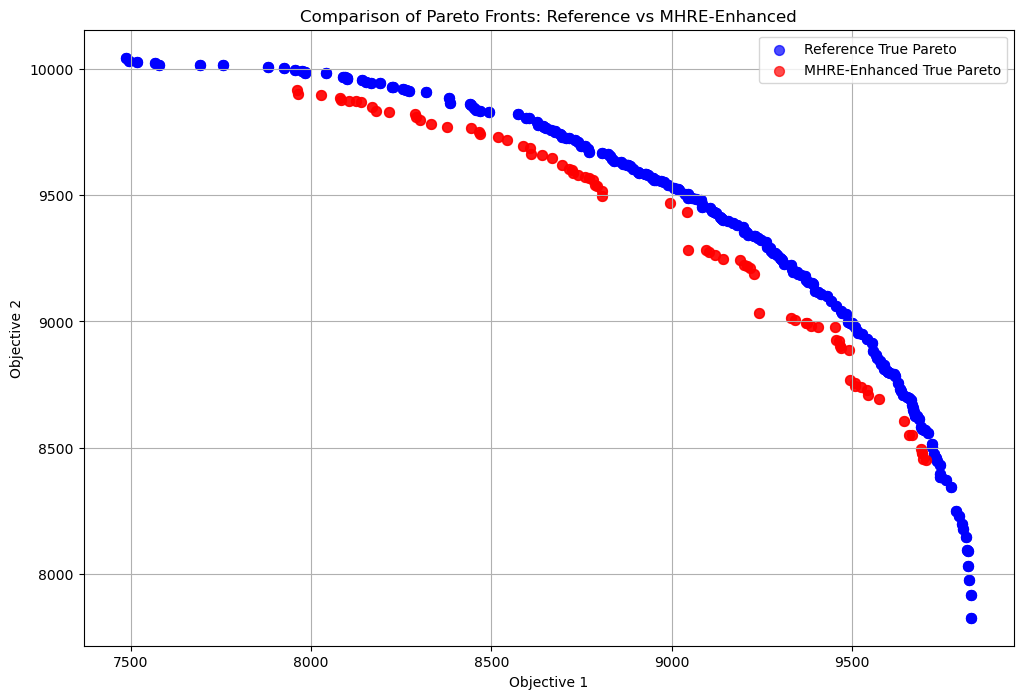

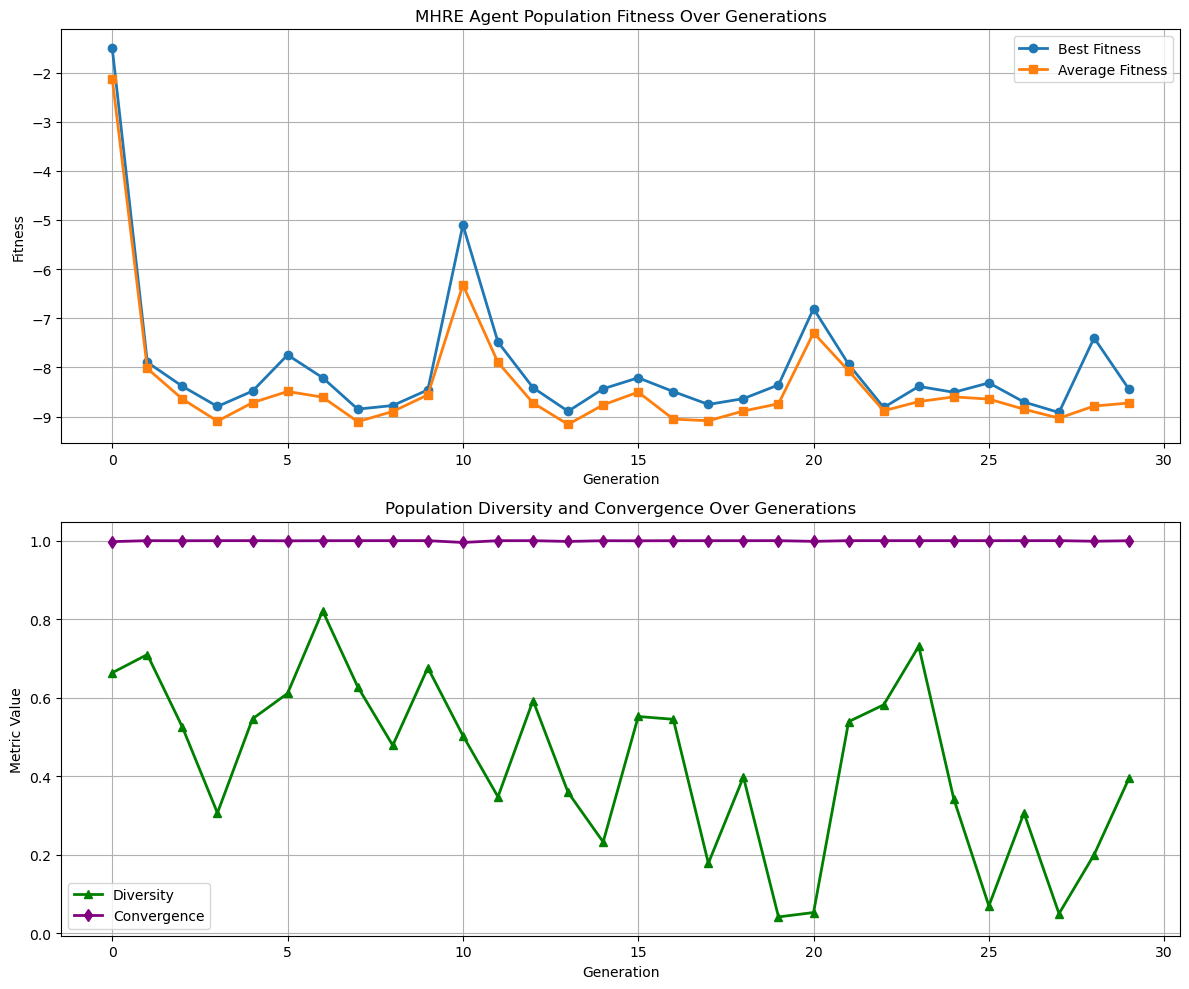

NameError: name 'move_stats' is not defined

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def load_pareto_front(filename):
    """Load Pareto front from file."""
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Check if a point is dominated by any other point."""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    """Extract the Pareto front from a set of points."""
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

def hypervolume(points, reference_point):
    """Calculate hypervolume indicator."""
    sorted_points = sorted(points, key=lambda x: x[0])
    volume = 0.0
    prev_x = reference_point[0]
    for point in sorted_points:
        width = prev_x - point[0]
        height = reference_point[1] - point[1]
        volume += width * height
        prev_x = point[0]
    return volume

def spacing(points):
    """Calculate spacing metric for Pareto front."""
    if len(points) < 2:
        return 0.0
    
    # Calculate distances between consecutive points
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))
    distances = []
    for i in range(len(sorted_points) - 1):
        dist = np.linalg.norm(np.array(sorted_points[i]) - np.array(sorted_points[i+1]))
        distances.append(dist)
    
    if not distances:
        return 0.0
    
    mean_dist = np.mean(distances)
    spacing_val = np.sqrt(np.sum([(d - mean_dist)**2 for d in distances]) / len(distances))
    return spacing_val

def spread(points, reference_point):
    """Calculate spread metric for Pareto front."""
    if len(points) < 2:
        return 0.0
    
    # Calculate extreme points
    sorted_by_obj1 = sorted(points, key=lambda x: x[0])
    sorted_by_obj2 = sorted(points, key=lambda x: x[1])
    
    extreme_points = [sorted_by_obj1[0], sorted_by_obj1[-1], sorted_by_obj2[0], sorted_by_obj2[-1]]
    
    # Calculate distances between consecutive points
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))
    distances = []
    for i in range(len(sorted_points) - 1):
        dist = np.linalg.norm(np.array(sorted_points[i]) - np.array(sorted_points[i+1]))
        distances.append(dist)
    
    if not distances:
        return 0.0
    
    mean_dist = np.mean(distances)
    
    # Calculate spread
    d_extreme = np.linalg.norm(np.array(extreme_points[0]) - np.array(extreme_points[-1]))
    spread_val = (d_extreme + np.sum([abs(d - mean_dist) for d in distances])) / (d_extreme + len(distances) * mean_dist)
    return spread_val

def igd(approximation, true_pareto):
    """Calculate Inverted Generational Distance."""
    if len(true_pareto) == 0 or len(approximation) == 0:
        return float('inf')
    
    # Calculate minimum distance from each true Pareto point to approximation
    min_distances = []
    for true_point in true_pareto:
        distances = [np.linalg.norm(np.array(true_point) - np.array(app_point)) for app_point in approximation]
        min_distances.append(min(distances))
    
    return np.sqrt(np.mean([d**2 for d in min_distances]))

# Load and compare results
print("Loading and comparing results...")
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("mhre_results.txt")

# Get Pareto fronts
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Calculate performance metrics
ref_point = np.max(np.vstack([ref_pareto, new_pareto]), axis=0) * 1.1

ref_hv = hypervolume(ref_pareto, ref_point)
new_hv = hypervolume(new_pareto, ref_point)

ref_spacing = spacing(ref_pareto)
new_spacing = spacing(new_pareto)

ref_spread = spread(ref_pareto, ref_point)
new_spread = spread(new_pareto, ref_point)

ref_igd = igd(ref_pareto, new_pareto)
new_igd = igd(new_pareto, ref_pareto)

# Print performance comparison
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Reference Pareto Front:")
print(f"  Size: {len(ref_pareto)}")
print(f"  Hypervolume: {ref_hv:.2f}")
print(f"  Spacing: {ref_spacing:.4f}")
print(f"  Spread: {ref_spread:.4f}")

print(f"\nMHRE-Enhanced Pareto Front:")
print(f"  Size: {len(new_pareto)}")
print(f"  Hypervolume: {new_hv:.2f}")
print(f"  Spacing: {new_spacing:.4f}")
print(f"  Spread: {new_spread:.4f}")

print(f"\nImprovements:")
print(f"  Hypervolume: {(new_hv - ref_hv) / ref_hv * 100:.2f}%")
print(f"  Spacing: {(ref_spacing - new_spacing) / ref_spacing * 100:.2f}% (lower is better)")
print(f"  Spread: {(ref_spread - new_spread) / ref_spread * 100:.2f}% (lower is better)")
print(f"  IGD: {(ref_igd - new_igd) / ref_igd * 100:.2f}% (lower is better)")

# Plot comparison
plt.figure(figsize=(12, 8))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7, color='blue', s=50)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="MHRE-Enhanced True Pareto", alpha=0.7, color='red', s=50)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("Comparison of Pareto Fronts: Reference vs MHRE-Enhanced")
plt.grid(True)
plt.savefig("pareto_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot agent performance over generations
if hasattr(agent_manager, 'performance_history') and agent_manager.performance_history:
    generations = [p['generation'] for p in agent_manager.performance_history]
    best_fitness = [p['best_fitness'] for p in agent_manager.performance_history]
    avg_fitness = [p['avg_fitness'] for p in agent_manager.performance_history]
    diversity = [p['diversity'] for p in agent_manager.performance_history]
    convergence = [p['convergence'] for p in agent_manager.performance_history]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot fitness
    ax1.plot(generations, best_fitness, label='Best Fitness', marker='o', linewidth=2)
    ax1.plot(generations, avg_fitness, label='Average Fitness', marker='s', linewidth=2)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness')
    ax1.set_title('MHRE Agent Population Fitness Over Generations')
    ax1.legend()
    ax1.grid(True)
    
    # Plot diversity and convergence
    ax2.plot(generations, diversity, label='Diversity', marker='^', linewidth=2, color='green')
    ax2.plot(generations, convergence, label='Convergence', marker='d', linewidth=2, color='purple')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Population Diversity and Convergence Over Generations')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("agent_performance.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot move type distribution
if move_stats and 'move_type_counts' in move_stats:
    move_types = list(move_stats['move_type_counts'].keys())
    counts = list(move_stats['move_type_counts'].values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(move_types, counts)
    plt.xlabel('Move Type')
    plt.ylabel('Usage Count')
    plt.title('Move Type Distribution in MHRE')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom')
    
    plt.savefig("move_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create a summary table
summary_data = {
    'Metric': ['Hypervolume', 'Spacing', 'Spread', 'IGD', 'Pareto Front Size'],
    'Reference': [ref_hv, ref_spacing, ref_spread, ref_igd, len(ref_pareto)],
    'MHRE-Enhanced': [new_hv, new_spacing, new_spread, new_igd, len(new_pareto)],
    'Improvement (%)': [
        (new_hv - ref_hv) / ref_hv * 100,
        (ref_spacing - new_spacing) / ref_spacing * 100,
        (ref_spread - new_spread) / ref_spread * 100,
        (ref_igd - new_igd) / ref_igd * 100,
        (len(new_pareto) - len(ref_pareto)) / len(ref_pareto) * 100
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== SUMMARY TABLE ===")
print(summary_df.to_string(index=False, float_format="%.2f"))

# Save summary table to CSV
summary_df.to_csv("performance_summary.csv", index=False)

print("\nMHRE implementation completed successfully!")
print("Results saved to:")
print("- pareto_comparison.png: Comparison of Pareto fronts")
print("- agent_performance.png: Agent performance over generations")
print("- move_distribution.png: Move type distribution")
print("- performance_summary.csv: Summary of performance metrics")

Loading and comparing results...

=== PERFORMANCE COMPARISON ===
Reference Pareto Front:
  Size: 848
  Hypervolume: -124044.92
  Spacing: 11.9794
  Spread: 1.5155

MHRE-Enhanced Pareto Front:
  Size: 156
  Hypervolume: 364414.68
  Spacing: 30.1760
  Spread: 1.1213

Improvements:
  Hypervolume: -393.78%
  Spacing: -151.90% (lower is better)
  Spread: 26.01% (lower is better)
  IGD: -57.86% (lower is better)


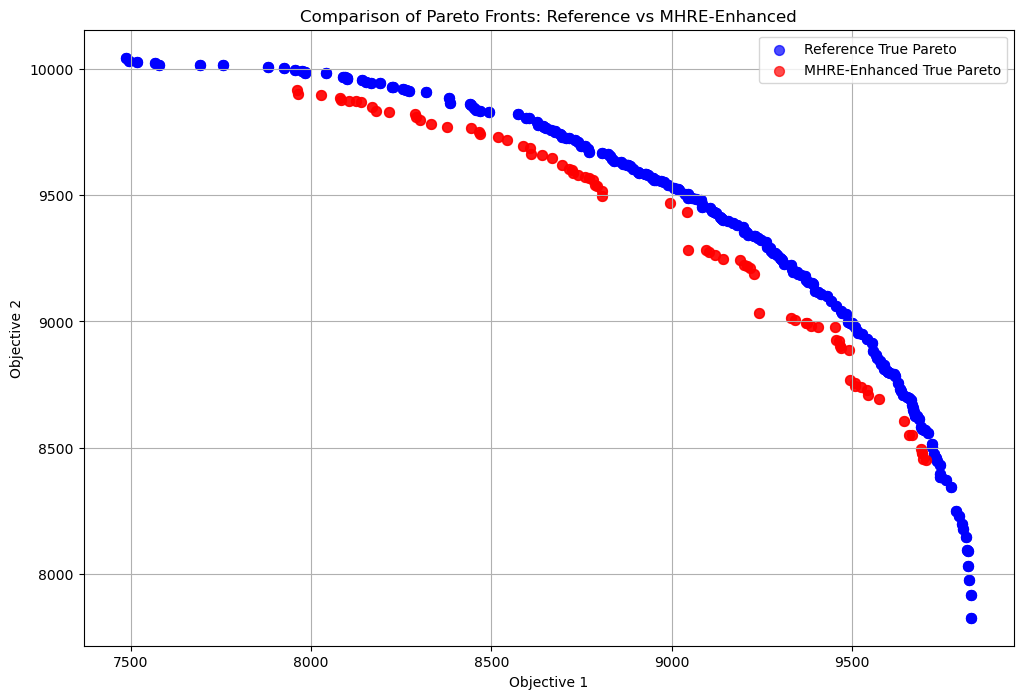

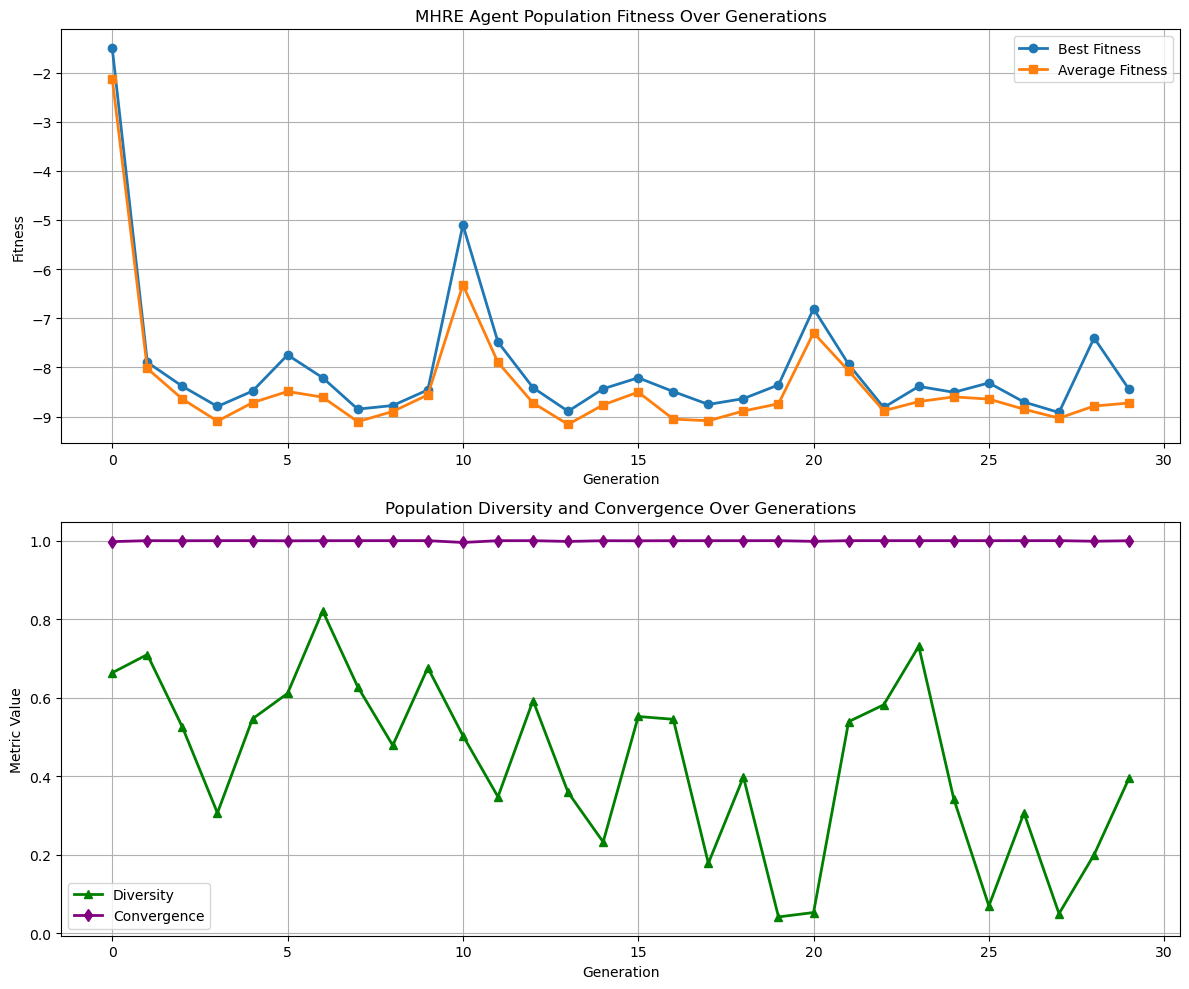

NameError: name 'move_stats' is not defined

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist, squareform

def load_pareto_front(filename):
    """Load Pareto front from file."""
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Check if a point is dominated by any other point."""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    """Extract the Pareto front from a set of points."""
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

def hypervolume(points, reference_point):
    """Calculate hypervolume indicator."""
    sorted_points = sorted(points, key=lambda x: x[0])
    volume = 0.0
    prev_x = reference_point[0]
    for point in sorted_points:
        width = prev_x - point[0]
        height = reference_point[1] - point[1]
        volume += width * height
        prev_x = point[0]
    return volume

def spacing(points):
    """Calculate spacing metric for Pareto front."""
    if len(points) < 2:
        return 0.0
    
    # Calculate distances between consecutive points
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))
    distances = []
    for i in range(len(sorted_points) - 1):
        dist = np.linalg.norm(np.array(sorted_points[i]) - np.array(sorted_points[i+1]))
        distances.append(dist)
    
    if not distances:
        return 0.0
    
    mean_dist = np.mean(distances)
    spacing_val = np.sqrt(np.sum([(d - mean_dist)**2 for d in distances]) / len(distances))
    return spacing_val

def spread(points, reference_point):
    """Calculate spread metric for Pareto front."""
    if len(points) < 2:
        return 0.0
    
    # Calculate extreme points
    sorted_by_obj1 = sorted(points, key=lambda x: x[0])
    sorted_by_obj2 = sorted(points, key=lambda x: x[1])
    
    extreme_points = [sorted_by_obj1[0], sorted_by_obj1[-1], sorted_by_obj2[0], sorted_by_obj2[-1]]
    
    # Calculate distances between consecutive points
    sorted_points = sorted(points, key=lambda x: (x[0], -x[1]))
    distances = []
    for i in range(len(sorted_points) - 1):
        dist = np.linalg.norm(np.array(sorted_points[i]) - np.array(sorted_points[i+1]))
        distances.append(dist)
    
    if not distances:
        return 0.0
    
    mean_dist = np.mean(distances)
    
    # Calculate spread
    d_extreme = np.linalg.norm(np.array(extreme_points[0]) - np.array(extreme_points[-1]))
    spread_val = (d_extreme + np.sum([abs(d - mean_dist) for d in distances])) / (d_extreme + len(distances) * mean_dist)
    return spread_val

def igd(approximation, true_pareto):
    """Calculate Inverted Generational Distance."""
    if len(true_pareto) == 0 or len(approximation) == 0:
        return float('inf')
    
    # Calculate minimum distance from each true Pareto point to approximation
    min_distances = []
    for true_point in true_pareto:
        distances = [np.linalg.norm(np.array(true_point) - np.array(app_point)) for app_point in approximation]
        min_distances.append(min(distances))
    
    return np.sqrt(np.mean([d**2 for d in min_distances]))

# Load and compare results
print("Loading and comparing results...")
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("mhre_results.txt")

# Get Pareto fronts
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Calculate performance metrics
ref_point = np.max(np.vstack([ref_pareto, new_pareto]), axis=0) * 1.1

ref_hv = hypervolume(ref_pareto, ref_point)
new_hv = hypervolume(new_pareto, ref_point)

ref_spacing = spacing(ref_pareto)
new_spacing = spacing(new_pareto)

ref_spread = spread(ref_pareto, ref_point)
new_spread = spread(new_pareto, ref_point)

ref_igd = igd(ref_pareto, new_pareto)
new_igd = igd(new_pareto, ref_pareto)

# Print performance comparison
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Reference Pareto Front:")
print(f"  Size: {len(ref_pareto)}")
print(f"  Hypervolume: {ref_hv:.2f}")
print(f"  Spacing: {ref_spacing:.4f}")
print(f"  Spread: {ref_spread:.4f}")

print(f"\nMHRE-Enhanced Pareto Front:")
print(f"  Size: {len(new_pareto)}")
print(f"  Hypervolume: {new_hv:.2f}")
print(f"  Spacing: {new_spacing:.4f}")
print(f"  Spread: {new_spread:.4f}")

print(f"\nImprovements:")
print(f"  Hypervolume: {(new_hv - ref_hv) / ref_hv * 100:.2f}%")
print(f"  Spacing: {(ref_spacing - new_spacing) / ref_spacing * 100:.2f}% (lower is better)")
print(f"  Spread: {(ref_spread - new_spread) / ref_spread * 100:.2f}% (lower is better)")
print(f"  IGD: {(ref_igd - new_igd) / ref_igd * 100:.2f}% (lower is better)")

# Plot comparison
plt.figure(figsize=(12, 8))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7, color='blue', s=50)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="MHRE-Enhanced True Pareto", alpha=0.7, color='red', s=50)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("Comparison of Pareto Fronts: Reference vs MHRE-Enhanced")
plt.grid(True)
plt.savefig("pareto_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot agent performance over generations
if hasattr(agent_manager, 'performance_history') and agent_manager.performance_history:
    generations = [p['generation'] for p in agent_manager.performance_history]
    best_fitness = [p['best_fitness'] for p in agent_manager.performance_history]
    avg_fitness = [p['avg_fitness'] for p in agent_manager.performance_history]
    diversity = [p['diversity'] for p in agent_manager.performance_history]
    convergence = [p['convergence'] for p in agent_manager.performance_history]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot fitness
    ax1.plot(generations, best_fitness, label='Best Fitness', marker='o', linewidth=2)
    ax1.plot(generations, avg_fitness, label='Average Fitness', marker='s', linewidth=2)
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness')
    ax1.set_title('MHRE Agent Population Fitness Over Generations')
    ax1.legend()
    ax1.grid(True)
    
    # Plot diversity and convergence
    ax2.plot(generations, diversity, label='Diversity', marker='^', linewidth=2, color='green')
    ax2.plot(generations, convergence, label='Convergence', marker='d', linewidth=2, color='purple')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Metric Value')
    ax2.set_title('Population Diversity and Convergence Over Generations')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("agent_performance.png", dpi=300, bbox_inches='tight')
    plt.show()

# Plot move type distribution
if move_stats and 'move_type_counts' in move_stats:
    move_types = list(move_stats['move_type_counts'].keys())
    counts = list(move_stats['move_type_counts'].values())
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(move_types, counts)
    plt.xlabel('Move Type')
    plt.ylabel('Usage Count')
    plt.title('Move Type Distribution in MHRE')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}',
                 ha='center', va='bottom')
    
    plt.savefig("move_distribution.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create a summary table
summary_data = {
    'Metric': ['Hypervolume', 'Spacing', 'Spread', 'IGD', 'Pareto Front Size'],
    'Reference': [ref_hv, ref_spacing, ref_spread, ref_igd, len(ref_pareto)],
    'MHRE-Enhanced': [new_hv, new_spacing, new_spread, new_igd, len(new_pareto)],
    'Improvement (%)': [
        (new_hv - ref_hv) / ref_hv * 100,
        (ref_spacing - new_spacing) / ref_spacing * 100,
        (ref_spread - new_spread) / ref_spread * 100,
        (ref_igd - new_igd) / ref_igd * 100,
        (len(new_pareto) - len(ref_pareto)) / len(ref_pareto) * 100
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== SUMMARY TABLE ===")
print(summary_df.to_string(index=False, float_format="%.2f"))

# Save summary table to CSV
summary_df.to_csv("performance_summary.csv", index=False)

print("\nMHRE implementation completed successfully!")
print("Results saved to:")
print("- pareto_comparison.png: Comparison of Pareto fronts")
print("- agent_performance.png: Agent performance over generations")
print("- move_distribution.png: Move type distribution")
print("- performance_summary.csv: Summary of performance metrics")